## Importing Dataset Cleaned by Matchms and Lookups

In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matchms import Scores, Spectrum
from matchms.importing import load_from_json



In [2]:
ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\User\\Data'
sys.path.insert(0, ROOT)

from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))


number of spectra: 112956


## Plotting peaks per spectrum

Text(0, 0.5, 'number of spectra in respective bin')

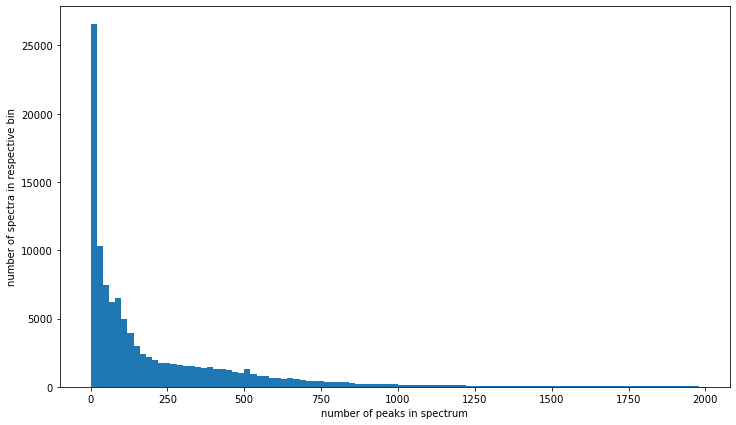

In [3]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]


plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

## Post-Process

Preparing data for cosine similarity scoring. Done by:

- normalize peaks (maximum intensity to 1)
- remove peaks outside [0, 1000] m/z window
- remove spectra with < 10 peaks
- remove peaks with intensities < 0.01 of maximum intensity.

In [4]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses
from matchms.filtering import reduce_to_number_of_peaks

def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    s = reduce_to_number_of_peaks(s, 10, 150, None)
    return s

# apply filters to the data
spectrums = [post_process(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums if s is not None]


print("Remaining spectra after post process", len(spectrums))



Remaining spectra after post process 69110


In [5]:
spectrumsblah = spectrums.copy()

len(spectrumsblah)


69110

In [6]:
def get_parent_peak(s): 
    precursor = s.metadata['precursor_mz']  
    condition = (s.peaks.mz >= precursor - 5) & (s.peaks.mz <= precursor + 5)
    mz_candidates = s.peaks.mz[condition]
    intensities_candidates = s.peaks.intensities[condition]
    if len(mz_candidates) is 0:
        return 0
    else: 
        max_index = np.argmax(intensities_candidates)
        return mz_candidates[max_index], intensities_candidates[max_index]
 
spectrumsblah = []

for spec in spectrums:
    if(get_parent_peak(spec) != 0):
        spectrumsblah.append(spec)
    
print(len(spectrumsblah))

for spec in spectrumsblah:
    if(get_parent_peak(spec) == 0):
        print("no peak here")
    

for spec in spectrumsblah[0:100]:
    print(get_parent_peak(spec))
    
    
    

39628
(982.221924, 0.03550841505095334)
(940.099915, 0.011557681217928113)
(545.082642, 1.0)
(314.110779, 0.01918109289458956)
(351.181885, 0.3987742554378137)
(439.357697, 0.3422915654693282)
(730.41748, 0.32221459074966236)
(752.399353, 1.0)
(861.585144, 1.0)
(866.630493, 0.7775384044896534)
(888.613281, 1.0)
(513.307617, 0.057068288462424836)
(535.289246, 1.0)
(990.596985, 0.55835655099359)
(578.332214, 0.057690787334075504)
(600.314148, 1.0)
(566.427185, 0.11061110525123509)
(606.9505, 0.340843443096476)
(515.321838, 0.3340167902452269)
(607.262451, 0.1559295801895918)
(584.284912, 0.14950831457986574)
(850.635437, 0.2467053597061022)
(348.154022, 0.10021788380630128)
(862.275696, 1.0)
(610.416504, 0.45563193731569374)
(848.25647, 0.7994926111877888)
(440.08667, 1.0)
(458.096893, 1.0)
(420.226349, 1.0)
(995.597229, 0.5478028802959782)
(325.227478, 0.04191079310323561)
(727.320129, 1.0)
(404.21991, 0.1516149951659739)
(426.201569, 1.0)
(601.357117, 1.0)
(410.282379, 0.23797567036414

150
60.40365398203291
10
150


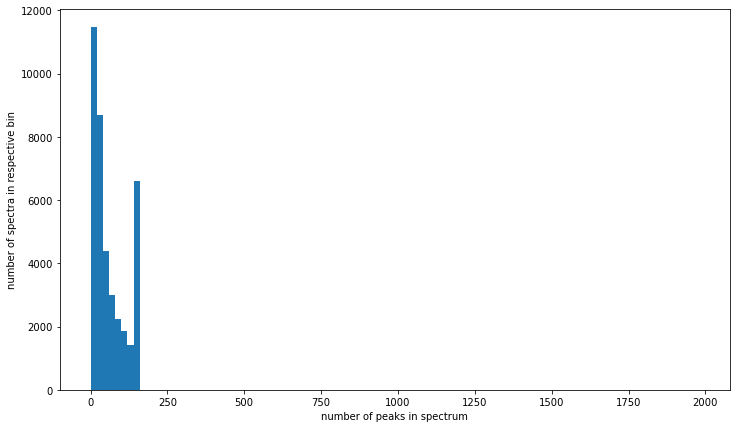

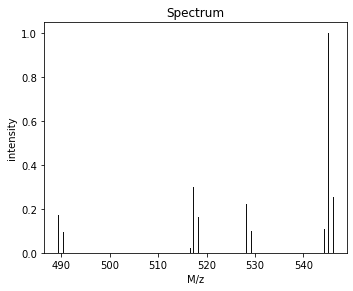

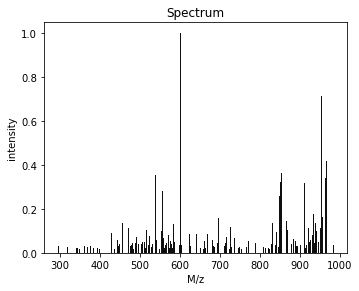

In [7]:
def analyse_spectrums(list):  

    number_of_peaks = [len(spec.peaks) for spec in list]
    plt.figure(figsize=(12,7))
    hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
    plt.xlabel("number of peaks in spectrum")
    plt.ylabel("number of spectra in respective bin")
    average = 0
    min = len(list[0].peaks.mz)
    max  = 0
    min_spec = None
    max_spec = None
    print(min)
    for spec in list:
        average += len(spec.peaks.mz) 
        if min > len(spec.peaks.mz):
            min = len(spec.peaks.mz)
            min_spec = spec
        if max < len(spec.peaks.mz):
            max = len(spec.peaks.mz)
            max_spec = spec
    average = average / len(list)
    print(average)
    print(min)
    min_spec.plot()
    print(max)
    max_spec.plot()
    
analyse_spectrums(spectrumsblah)


In [8]:
import random

spectrums2 = random.sample(spectrumsblah, 2000)

random.shuffle(spectrums2)

no_decoy_spectrums = spectrums2[1000:]
with_decoy_spectrums = spectrums2[:1000]

print(len(no_decoy_spectrums))
print(len(no_decoy_spectrums))

1000
1000


112
61.256
10
150
28
61.92
10
150


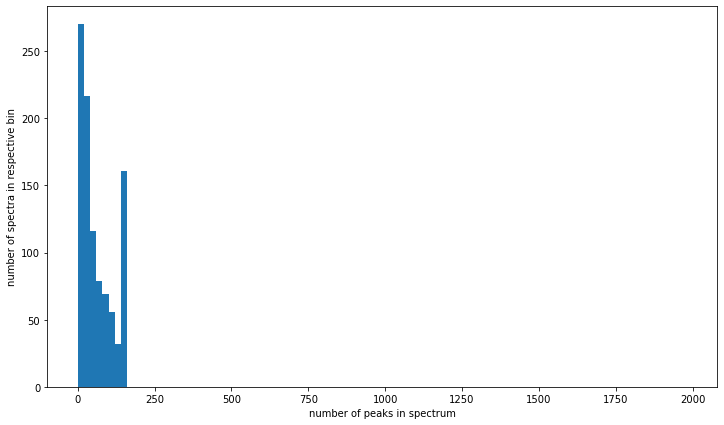

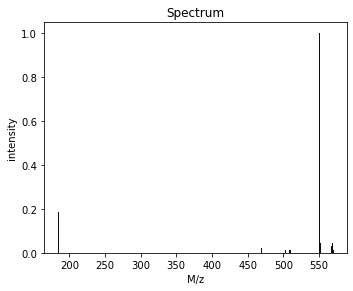

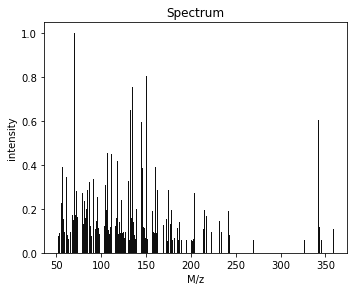

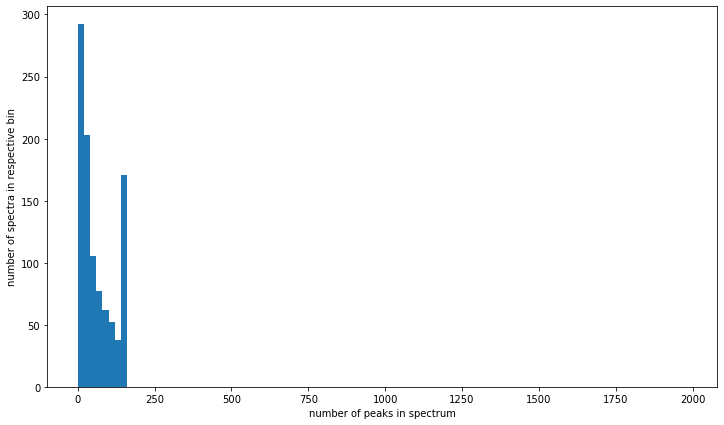

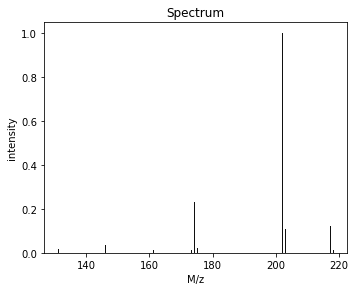

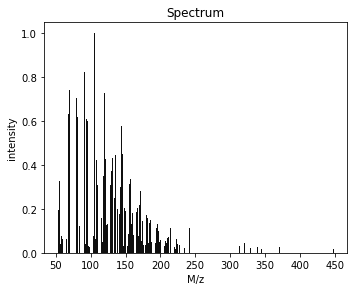

In [9]:
analyse_spectrums(no_decoy_spectrums)
analyse_spectrums(with_decoy_spectrums)

In [10]:
from numpy.random import seed
from numpy.random import rand




class fragment_peak:
    mz = 0
    intensity = 0
    spectrum_id = ""
    
    def __init__(self, mz, intensity, spectrum_id):
        self.mz = mz
        self.intensity = intensity
        self.spectrum_id = spectrum_id   
    
    def __lt__(self, other):
        return self.mz < other.mz

    def _eq_(self, other):
        return self.mz == other.mz
    
    def print_fragment(self):
        print("Peak with mz: ", self.mz, ", intensity: ", self.intensity, ", from spectrum: ", self.spectrum_id)
   
    

frag1 = fragment_peak(spectrums[3].peaks.mz[1], spectrums[3].peaks.intensities[1], spectrums[3].get('spectrum_id'))
frag2 = fragment_peak(spectrums[1].peaks.mz[1], spectrums[1].peaks.intensities[1], spectrums[1].get('spectrum_id'))
frag3 = fragment_peak(spectrums[2].peaks.mz[1], spectrums[2].peaks.intensities[1], spectrums[2].get('spectrum_id'))
frag4 = fragment_peak(spectrums[5].peaks.mz[1], spectrums[5].peaks.intensities[1], spectrums[5].get('spectrum_id'))
frag5 = fragment_peak(spectrums[6].peaks.mz[1], spectrums[6].peaks.intensities[1], spectrums[6].get('spectrum_id'))

frag_list = [frag1, frag2, frag3, frag4, frag5]
frag_order = [f.mz for f in frag_list]

print(frag_order)

frag_list_sorted = sorted(frag_list)
frag_list_sorted_order = [f.mz for f in frag_list_sorted]

print(frag_list_sorted_order)





[103.028542, 503.328186, 490.31311, 101.115685, 370.177979]
[101.115685, 103.028542, 370.177979, 490.31311, 503.328186]


In [11]:
import bisect
import operator

def index(a, x):
    'Locate the leftmost value exactly equal to x'
    i = bisect.bisect_left(a, x)
    if i != len(a) and a[i] == x:
        return i
    raise ValueError

def find_lt(a, x):
    'Find rightmost value less than x'
    i = bisect.bisect_left(a, x)
    if i:
        return a[i-1]
    raise ValueError

def find_le(a, x):
    'Find rightmost value less than or equal to x'
    i = bisect.bisect_right(a, x)
    if i:
        return a[i-1]
    raise ValueError

def find_gt(a, x):
    'Find leftmost value greater than x'
    i = bisect.bisect_right(a, x)
    if i != len(a):
        return a[i]
    raise ValueError

def find_ge(a, x):
    'Find leftmost item greater than or equal to x'
    i = bisect.bisect_left(a, x)
    if i != len(a):
        return a[i]
    raise ValueError
    
def find_frags_in_range(a, x, y):  
    i = bisect.bisect_left(a, x)
    j = bisect.bisect_right(a,y)
    return a[i:j]

def find_randomfrags_in_spec(fraglist, id): 
    indices = [i for i, x in enumerate(fraglist) if x.spectrum_id == id]
    frags = [fraglist[i] for i in indices]
    randomfrags = random.sample(frags, 5)
    return randomfrags
    
    
    
   # indices = [i for i, x in enumerate(fraglist) if x.spectrum_id == id]
   # print("Indices are: ", indices)
   #  print(type(indices[0]))
   # print(type(indices[2]))
   # fragments = fraglist[indices] frags = operator.itemgetter(*fraglist)(indices)
   # randomfragments = random.sample(fragments, 5)
   # return randomfragments
    
    
    
    

In [12]:
All_fragments_list = []

j = 0;

for spec in with_decoy_spectrums :
    i = 0;
    for p in spec.peaks.mz:
        frag = fragment_peak(spec.peaks.mz[i], spec.peaks.intensities[i], spec.get('spectrum_id'))
        i += 1
        All_fragments_list.append(frag)  
    print("Full spectrum turned to ", i, " fragments ")
    print(len(All_fragments_list), " frags in list")
    print(j, " of ", len(with_decoy_spectrums), " spectrums turned to fragment objects.")
    j += 1   
    
    


Full spectrum turned to  28  fragments 
28  frags in list
0  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  54  fragments 
82  frags in list
1  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  10  fragments 
92  frags in list
2  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  109  fragments 
201  frags in list
3  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  13  fragments 
214  frags in list
4  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  126  fragments 
340  frags in list
5  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  48  fragments 
388  frags in list
6  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  117  fragments 
505  frags in list
7  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  47  fragments 
552  frags in list
8  of  1000  spectrums turned to fragment objects.
Full spect

Full spectrum turned to  10  fragments 
4950  frags in list
81  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  14  fragments 
4964  frags in list
82  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  107  fragments 
5071  frags in list
83  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  69  fragments 
5140  frags in list
84  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  11  fragments 
5151  frags in list
85  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  18  fragments 
5169  frags in list
86  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  36  fragments 
5205  frags in list
87  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  12  fragments 
5217  frags in list
88  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  16  fragments 
5233  frags in list
89  of  1000  spectrums turned to fragment 

Full spectrum turned to  18  fragments 
10896  frags in list
181  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  77  fragments 
10973  frags in list
182  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  17  fragments 
10990  frags in list
183  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  150  fragments 
11140  frags in list
184  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  62  fragments 
11202  frags in list
185  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  10  fragments 
11212  frags in list
186  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  20  fragments 
11232  frags in list
187  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  92  fragments 
11324  frags in list
188  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  12  fragments 
11336  frags in list
189  of  1000  spectrums t

Full spectrum turned to  150  fragments 
16756  frags in list
272  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  14  fragments 
16770  frags in list
273  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  12  fragments 
16782  frags in list
274  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  20  fragments 
16802  frags in list
275  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  150  fragments 
16952  frags in list
276  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  14  fragments 
16966  frags in list
277  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  150  fragments 
17116  frags in list
278  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  32  fragments 
17148  frags in list
279  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  65  fragments 
17213  frags in list
280  of  1000  spectrums

22600  frags in list
372  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  52  fragments 
22652  frags in list
373  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  150  fragments 
22802  frags in list
374  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  150  fragments 
22952  frags in list
375  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  33  fragments 
22985  frags in list
376  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  32  fragments 
23017  frags in list
377  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  111  fragments 
23128  frags in list
378  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  72  fragments 
23200  frags in list
379  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  150  fragments 
23350  frags in list
380  of  1000  spectrums turned to fragment objects.
Full spect

Full spectrum turned to  27  fragments 
28830  frags in list
465  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  25  fragments 
28855  frags in list
466  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  41  fragments 
28896  frags in list
467  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  15  fragments 
28911  frags in list
468  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  13  fragments 
28924  frags in list
469  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  17  fragments 
28941  frags in list
470  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  21  fragments 
28962  frags in list
471  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  64  fragments 
29026  frags in list
472  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  138  fragments 
29164  frags in list
473  of  1000  spectrums t

Full spectrum turned to  24  fragments 
34183  frags in list
557  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  114  fragments 
34297  frags in list
558  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  28  fragments 
34325  frags in list
559  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  28  fragments 
34353  frags in list
560  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  100  fragments 
34453  frags in list
561  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  150  fragments 
34603  frags in list
562  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  67  fragments 
34670  frags in list
563  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  29  fragments 
34699  frags in list
564  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  12  fragments 
34711  frags in list
565  of  1000  spectrums

Full spectrum turned to  18  fragments 
40158  frags in list
653  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  125  fragments 
40283  frags in list
654  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  16  fragments 
40299  frags in list
655  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  33  fragments 
40332  frags in list
656  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  36  fragments 
40368  frags in list
657  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  44  fragments 
40412  frags in list
658  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  150  fragments 
40562  frags in list
659  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  18  fragments 
40580  frags in list
660  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  82  fragments 
40662  frags in list
661  of  1000  spectrums 

Full spectrum turned to  150  fragments 
45999  frags in list
748  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  10  fragments 
46009  frags in list
749  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  25  fragments 
46034  frags in list
750  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  90  fragments 
46124  frags in list
751  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  30  fragments 
46154  frags in list
752  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  106  fragments 
46260  frags in list
753  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  120  fragments 
46380  frags in list
754  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  150  fragments 
46530  frags in list
755  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  15  fragments 
46545  frags in list
756  of  1000  spectrum

Full spectrum turned to  150  fragments 
51933  frags in list
839  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  91  fragments 
52024  frags in list
840  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  22  fragments 
52046  frags in list
841  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  15  fragments 
52061  frags in list
842  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  126  fragments 
52187  frags in list
843  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  12  fragments 
52199  frags in list
844  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  17  fragments 
52216  frags in list
845  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  26  fragments 
52242  frags in list
846  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  12  fragments 
52254  frags in list
847  of  1000  spectrums 

Full spectrum turned to  17  fragments 
58083  frags in list
940  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  124  fragments 
58207  frags in list
941  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  150  fragments 
58357  frags in list
942  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  150  fragments 
58507  frags in list
943  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  16  fragments 
58523  frags in list
944  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  36  fragments 
58559  frags in list
945  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  65  fragments 
58624  frags in list
946  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  10  fragments 
58634  frags in list
947  of  1000  spectrums turned to fragment objects.
Full spectrum turned to  128  fragments 
58762  frags in list
948  of  1000  spectrum

In [13]:
print("Unsorted fragments lists:")

for i in range(20):
    All_fragments_list[i].print_fragment()
    
all_fragments_list_sorted = sorted(All_fragments_list)

print("Sorted by MZs: ")

for i in range(20):
    all_fragments_list_sorted[i].print_fragment()
    


Unsorted fragments lists:
Peak with mz:  72.044022 , intensity:  1.0 , from spectrum:  CCMSLIB00001058480
Peak with mz:  73.046707 , intensity:  0.026421644258320477 , from spectrum:  CCMSLIB00001058480
Peak with mz:  106.065331 , intensity:  0.03000581080810307 , from spectrum:  CCMSLIB00001058480
Peak with mz:  118.065216 , intensity:  0.05780501733223796 , from spectrum:  CCMSLIB00001058480
Peak with mz:  119.073166 , intensity:  0.013354840002404472 , from spectrum:  CCMSLIB00001058480
Peak with mz:  128.06189 , intensity:  0.08575951269361011 , from spectrum:  CCMSLIB00001058480
Peak with mz:  129.010208 , intensity:  0.01996212956098343 , from spectrum:  CCMSLIB00001058480
Peak with mz:  139.005936 , intensity:  0.14462900995852285 , from spectrum:  CCMSLIB00001058480
Peak with mz:  145.063965 , intensity:  0.011441280782254995 , from spectrum:  CCMSLIB00001058480
Peak with mz:  147.06897 , intensity:  0.011283487286352615 , from spectrum:  CCMSLIB00001058480
Peak with mz:  149.0

[0.01391313 0.01635743 0.01605408 0.02261734 0.09708377 0.01157072
 0.01168995 0.01080493 0.02698769 0.02767469 0.05053915 0.01730735
 0.02799939 0.01050417 0.05034908 0.10445138 0.03000572 0.02465689
 0.01190587 0.01164277 0.06255785 0.01676787 0.02123926 0.19262333
 0.03699149 0.02195295 0.01209031 0.01148244 0.02277608 0.02250981
 0.08005338 0.01517066 0.01999449 0.02542604 0.01101016 0.02304086
 0.01699623 0.17101522 0.02485011 0.04967687 0.01526996 0.09899251
 0.01933834 0.02395462 0.51071955 0.12347332 0.17312992 0.0467525
 0.42173288 0.11106008 0.16352988 0.03956639 1.         0.21442898
 0.01155768]
[0.17227341 0.09588521 0.02330222 0.30144447 0.16313245 0.22332947
 0.09954039 0.10859742 1.         0.25634027]


Text(0, 0.5, 'number of spectra in respective bin')

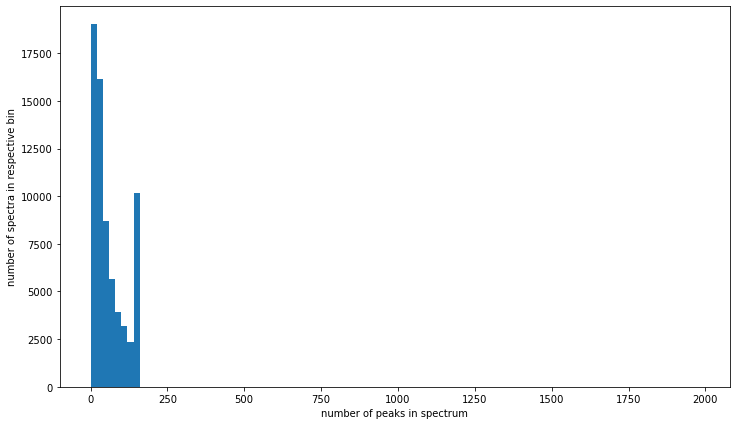

In [14]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

print(spectrums[1].peaks.intensities)
print(spectrums[2].peaks.intensities)

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

## Naive Decoy Approach

For the naive decoy spectral library, we use all possible fragment ions from the reference library of spectra and then randomly add these ions to the decoy spectra library, until each decoy spectrum reaches the desired number of fragment ions that mimics the corresponding library spectrum. This method is presented as a baseline evaluation of the other, more intricate methods.

1. Determine if there is a parent peak in target spectrum
2. If parent peak = false, move to next spectrum in target spectra list.
3. If parent peak = true, add to new decoy object:
   - The parent peak is added to the array of peaks in the new decoy object
4. Find number of peaks in target spectrum (the length of the list containing all peaks)
5. Select that number of spectra randomly from the list of all spectra in target list
6. Select from each of those individually a random peak
7. Add those peaks to the list of peaks in the decoy spectrum, until number peaks in decoy spectrum = number of peaks in target spectrum. 
8. Add new complete decoy spectrum to decoy spectra library (naive)



public Peak getParentPeak(Spectrum s) {
        Peak parentpeak;
        ArrayList<Peak> candidatepeaks = new ArrayList<Peak>;
        Peak p = s.getPrecursor;
        for(Peak counterpeak : s.getPeaks()) {
            if(counterpeak.getMass >= p.getMass - 5 && counterpeak.getMass <= p.getMass + 5) {
               candidatepeaks.add(counterpeak);
               }
            }  
         if(candidatepeaks.size() == 0) {
            system.out.print("No parent peak found")
                                                                                      
            }
         else {                                                                   
               for(Peak p : candidatepeaks) {
                  if(p.getIntensity() > parentpeak.getIntensity()) {
                     parentpeak = p
                    }
         return parentpeak; 
    
  
    
                                                                                    
                                                                                  
 public spectrum createDecoy(Spectrum s) {  
         parent = getParentPeak(s);
         if(parent == none) {
                system.out.print("No parent peak detected: decoy not created.")
                return null;
                 }
         else {
                 Spectrum decoy = new Spectrum();
                 decoy.peaks.addPeak(parent);
                 Int peaksrequired = s.peaks.size() - 1;
                 for(int i = 0; i < peaksrequired; i++) {
                     ArrayList<Peak> possiblepeaks = new ArrayList<Peak>;                             
                     Random r = new Random() (range 0 to spectrums.size());
                     possiblepeaks = spectrums(r).getPeaks();
                     Random r2 = new Random() (range 0 to possiblepeaks.size());
                     decoy.peaks.addPeak(possiblepeaks(r2));
                    }
                  return decoy; 
                     
                     
              
         
         

In [15]:
from matchms.Spikes import Spikes
import random



def get_spectrum_info(s):
    print(s.peaks.mz)
    precursor = s.metadata['precursor_mz']
    print("Precursor spectrum is: ", precursor)
    print("Number of  peaks in spectrum is: ", len(s.peaks) )
    masses = s.peaks.mz
    print(masses)
    print(s.peaks.intensities)     
    mz = s.peaks.mz
    intensities = s.peaks.intensities
    print(intensities)
    s.plot()


def ispeakhere(s, f):
    
    return np.any((s.peaks.mz >= f - 5) & (s.peaks.mz <= f + 5))                                         


def masswithin5ppm(m,range):
    ishere = 0
    for r in range:
        if m >= r - 5 and m <= r + 5:
            ishere = 1
            break
    return ishere
    
    








In [16]:
naive_decoy_spectrums = []



def create_naive_decoy(s):
    print(get_parent_peak(s))
    decoy_mz = np.array([get_parent_peak(s)[0]])
    decoy_intensity = np.array([get_parent_peak(s)[1]])                        
    peaks_in_target = len(s.peaks.mz)

    random_spectrums = random.sample(with_decoy_spectrums, peaks_in_target - 1)

    for spec in random_spectrums:
        randommass =  random.choice(spec.peaks.mz)
        index = np.where(spec.peaks.mz == randommass)
        randomintensity = spec.peaks.intensities[index]
        decoy_mz = np.append(decoy_mz, [randommass])
        decoy_intensity = np.append(decoy_intensity, [randomintensity])
        


    decoy_mz = np.asarray(decoy_mz, dtype=float) 
    decoy_intensity = np.asarray(decoy_intensity, dtype=float) 

    inds  = decoy_mz.argsort()

    sorted_intensities = decoy_intensity[inds]
    sorted_mzs = decoy_mz[inds]

    decoy = Spectrum(sorted_mzs, sorted_intensities) 

    naive_decoy_spectrums.append(decoy)
       

                            
print( "Total processed peaks = ", len(naive_decoy_spectrums))

i = 1

for spec in with_decoy_spectrums:
    create_naive_decoy(spec)
    print(i, " naive decoy created")
    i += 1


print( "Total processed peaks = ", len(naive_decoy_spectrums))

# print(condition)

Total processed peaks =  0
(291.090393, 0.6971892720460056)
1  naive decoy created
(496.269501, 1.0)
2  naive decoy created
(217.047, 0.1241241)
3  naive decoy created
(304.022552, 0.010402532790592492)
4  naive decoy created
(261.130524, 1.0)
5  naive decoy created
(325.167603, 0.10262172284644194)
6  naive decoy created
(209.081055, 0.21333574666330898)
7  naive decoy created
(287.055847, 0.15465116279069768)
8  naive decoy created
(422.045563, 1.0)
9  naive decoy created
(477.30249, 0.04044095)
10  naive decoy created
(648.626221, 0.04307393307173605)
11  naive decoy created
(335.126984, 0.26720402)
12  naive decoy created
(447.346344, 0.01857681)
13  naive decoy created
(285.0221, 0.03694324)
14  naive decoy created
(625.610657, 0.43439463426431907)
15  naive decoy created
(817.196228, 0.31741713)
16  naive decoy created
(699.365417, 0.014068519537699505)
17  naive decoy created
(282.131134, 0.017311524757474384)
18  naive decoy created
(597.222595, 0.0360569)
19  naive decoy creat

174  naive decoy created
(836.515625, 0.08838969995578534)
175  naive decoy created
(460.950623, 0.0793407)
176  naive decoy created
(241.085861, 0.12703919)
177  naive decoy created
(155.029755, 0.09202453987730061)
178  naive decoy created
(903.80481, 0.3711687020999144)
179  naive decoy created
(970.071045, 0.3443749851847578)
180  naive decoy created
(607.276611, 1.0)
181  naive decoy created
(503.306702, 0.16541135142780086)
182  naive decoy created
(350.186951, 1.0)
183  naive decoy created
(160.1332, 0.30307414)
184  naive decoy created
(557.43866, 0.04883329)
185  naive decoy created
(387.177765, 0.01101352)
186  naive decoy created
(597.67688, 0.1502361623948809)
187  naive decoy created
(327.195068, 0.1622705720311275)
188  naive decoy created
(515.27771, 0.4894323455908604)
189  naive decoy created
(749.726624, 0.055677929034071)
190  naive decoy created
(375.177612, 0.6811911756025644)
191  naive decoy created
(723.612793, 0.9382614446704678)
192  naive decoy created
(203.1

338  naive decoy created
(349.182495, 1.0)
339  naive decoy created
(385.191376, 0.35069427)
340  naive decoy created
(405.114594, 0.030787520000000002)
341  naive decoy created
(271.060699, 1.0)
342  naive decoy created
(309.045563, 1.0)
343  naive decoy created
(569.383362, 0.408741857561885)
344  naive decoy created
(925.642212, 0.07584537)
345  naive decoy created
(344.828979, 0.15542756000000002)
346  naive decoy created
(593.625, 0.31304582875055387)
347  naive decoy created
(465.1033, 0.040496977837474815)
348  naive decoy created
(273.166656, 0.17238283)
349  naive decoy created
(204.074814, 0.020115211462383025)
350  naive decoy created
(827.779968, 0.973116653190032)
351  naive decoy created
(475.122894, 1.0)
352  naive decoy created
(372.148102, 0.01320901320901321)
353  naive decoy created
(391.283875, 0.04908225143461804)
354  naive decoy created
(425.213928, 0.4993652)
355  naive decoy created
(439.266388, 1.0)
356  naive decoy created
(704.611023, 1.0)
357  naive decoy c

(319.109772, 0.38062471510126117)
501  naive decoy created
(358.367523, 0.23050251)
502  naive decoy created
(335.259979, 0.17085938870764397)
503  naive decoy created
(331.047333, 1.0)
504  naive decoy created
(381.260925, 0.10346593)
505  naive decoy created
(335.203003, 0.08530942741469057)
506  naive decoy created
(355.152374, 1.0)
507  naive decoy created
(812.732605, 0.14687619004398095)
508  naive decoy created
(303.017273, 0.08406344)
509  naive decoy created
(175.148132, 0.13969094)
510  naive decoy created
(313.234283, 1.0)
511  naive decoy created
(183.080109, 0.0582067627262335)
512  naive decoy created
(595.386169, 0.02971126)
513  naive decoy created
(249.167816, 0.012291303677623974)
514  naive decoy created
(301.143036, 0.01218578)
515  naive decoy created
(633.455017, 0.03387884)
516  naive decoy created
(443.315613, 0.7976499189627229)
517  naive decoy created
(195.948776, 0.09867103999999999)
518  naive decoy created
(905.912781, 0.20282693891704048)
519  naive decoy

674  naive decoy created
(957.783936, 0.02919780472980533)
675  naive decoy created
(324.325714, 1.0)
676  naive decoy created
(437.234894, 0.24127521999999998)
677  naive decoy created
(652.535461, 0.015210040527006129)
678  naive decoy created
(290.050537, 0.8909090909090909)
679  naive decoy created
(174.0543, 1.0)
680  naive decoy created
(271.0324, 0.05239528)
681  naive decoy created
(320.192444, 0.06932952924393723)
682  naive decoy created
(392.204102, 1.0)
683  naive decoy created
(358.122131, 1.0)
684  naive decoy created
(449.286682, 1.0)
685  naive decoy created
(411.170471, 0.12283444576696158)
686  naive decoy created
(449.105591, 0.08615384615384615)
687  naive decoy created
(413.263397, 0.7117235345581803)
688  naive decoy created
(277.177307, 0.0157244)
689  naive decoy created
(670.151184, 0.017538100581973824)
690  naive decoy created
(567.538513, 1.0)
691  naive decoy created
(418.11673, 0.46249186999999997)
692  naive decoy created
(623.520813, 0.07999612)
693  nai

840  naive decoy created
(271.228333, 0.3834708212074134)
841  naive decoy created
(368.112549, 0.18181332)
842  naive decoy created
(834.769348, 0.5611097474473372)
843  naive decoy created
(283.030182, 0.33899028999999997)
844  naive decoy created
(204.140228, 1.0)
845  naive decoy created
(400.015228, 0.10265737180299318)
846  naive decoy created
(708.45282, 1.0)
847  naive decoy created
(839.574463, 0.05651818992296938)
848  naive decoy created
(373.273132, 0.0678097293240137)
849  naive decoy created
(273.167023, 0.13776198)
850  naive decoy created
(834.788086, 0.01507002081130322)
851  naive decoy created
(183.0916, 0.4082919079587967)
852  naive decoy created
(425.556763, 0.016374279199846933)
853  naive decoy created
(255.211578, 0.19339521218613726)
854  naive decoy created
(459.328369, 1.0)
855  naive decoy created
(459.085297, 0.06832882223019017)
856  naive decoy created
(481.0982, 0.030286091549295777)
857  naive decoy created
(291.4, 0.11824324324324324)
858  naive decoy

[131.048 146.035 161.057 173.057 174.029 175.033 202.024 203.027 217.047
 218.05 ]
Precursor spectrum is:  217.05
Number of  peaks in spectrum is:  10
[131.048 146.035 161.057 173.057 174.029 175.033 202.024 203.027 217.047
 218.05 ]
[0.017017  0.034034  0.013013  0.012012  0.2332332 0.02002   1.
 0.1081081 0.1241241 0.014014 ]
[0.017017  0.034034  0.013013  0.012012  0.2332332 0.02002   1.
 0.1081081 0.1241241 0.014014 ]
[ 72.044022  73.046707 106.065331 118.065216 119.073166 128.06189
 129.010208 139.005936 145.063965 147.06897  149.015472 154.065506
 155.061783 156.062119 163.031494 163.087997 164.03476  164.095001
 168.056793 175.031662 183.06778  190.042252 218.037674 219.041702
 220.034119 246.033401 291.090393 292.093353]
Precursor spectrum is:  291.089
Number of  peaks in spectrum is:  28
[ 72.044022  73.046707 106.065331 118.065216 119.073166 128.06189
 129.010208 139.005936 145.063965 147.06897  149.015472 154.065506
 155.061783 156.062119 163.031494 163.087997 164.03476  164

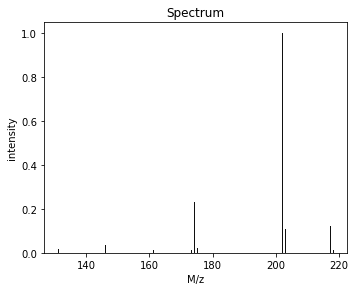

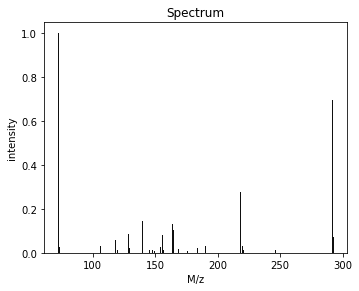

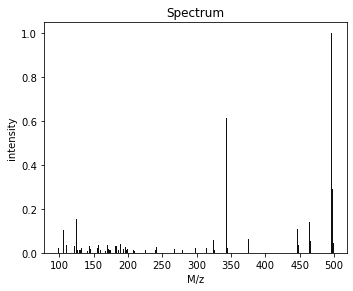

In [17]:
get_spectrum_info(with_decoy_spectrums[2])
get_spectrum_info(with_decoy_spectrums[0])
get_spectrum_info(with_decoy_spectrums[1])

1000


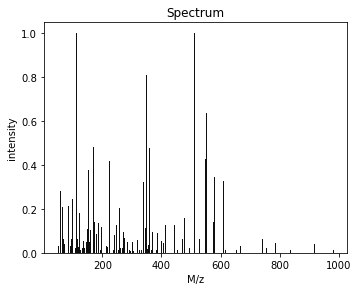

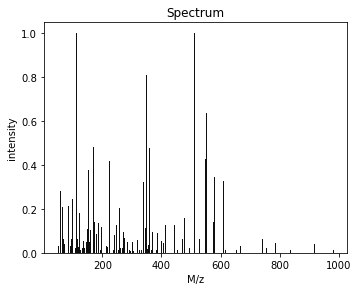

In [18]:
print(len(naive_decoy_spectrums))
naive_decoy_spectrums[3].plot()


      
      


## Spectrum-based Decoy Approach

The second method is similar to the naive method, as we create the decoy spectral library through choosing fragment ions that co-appear in the spectra from the target spectral library (Fig. 1c): In this spectrum-based approach, we start with an empty set of fragment ion candidates. First, the precursor fragment ion of the target spectrum is added to the decoy spectrum. For each fragment ion added to the decoy spectrum, we choose all spectra from the target spectral library which contain this fragment ion, within a mass range of 5 p.p.m. From these spectra, we uniformly draw (all fragment ions have the same probability to be drawn) five fragment ions that are added to the fragment ion candidate set; we use all fragment ions in case there are fewer than five. We draw a fragment ion from the fragment ion candidate set and add it to the decoy spectrum, then proceed as described above until we reach the desired number of fragment ions that mimics the corresponding library spectrum. The two-step process of first drawing candidates, then drawing the actual decoy spectrum was introduced to better mimic fragmentation cascades and dependencies between fragments. Furthermore, it prevents that fragment-rich spectra dominate the process. Out of the five added candidate fragment ions, between zero and five end up in the final decoy spectrum. Fragment ions with mass close (5 p.p.m.) to a previously added fragment ion mass, or masses above the precursor fragment ion mass are discarded. If the precursor ion is absent from the MS/MS spectrum, we use the selected ion mass to find matching compound masses. 

1. Determine if there is a parent peak in target spectrum
2. If parent peak = false, move to next spectrum in target spectra list.
3. If parent peak = true, add to new decoy spectrum object:
   - The parent peak is added to the array of peaks in the new decoy object
4. Create a list of all spectra from the target list that contain the same fragment ion (search all peaks for a mass identical to or within a close range of the parent peak - mass range of 5 p.p.m)
5. Create an empty list of candidate fragment ions that will be drawn from
6. Draw 5 fragment ions from each of the spectra on list created at step 4 and add those to candidate list created at step 5
7. Randomly draw a fragment ion from the candidate list:
   - If its mass < precursor peak of target spectrum AND is not within 5 p.p.m of any other peak, then the peak is added to the      decoy spectrum's list of peaks.
   - If it fails either of the conditions above, it is discarded and another candidate fragment is drawn.
8. Repeat step 4- 7 until number peaks in decoy spectrum = number of peaks in target spectrum. 
9. Add completed decoy to decoy spectral library. 


In [19]:
complex_decoy_spectrums = []

    # fragments = all_fragments_list_sorted[x:y] 'CCMSLIB00004717811'
    # original_spectrums = [f.spectrum_id for f in fragments]
    # final_spectrums = list(dict.fromkeys(original_spectrums))

In [20]:
def random_sample_5_peaks(spectrum_id):
    frag_list =[x for x in All_fragments_list if x.spectrum_id == spectrum_id]
    frag_list = random.sample(frag_list, 5)
    return frag_list


In [29]:
def get_spectrums_with_peak(mz):
    x = fragment_peak(mz - 5, 0, 'counter')
    y = fragment_peak(mz + 5, 0, 'counter2')
    x = find_ge(all_fragments_list_sorted, x)
    y = find_le(all_fragments_list_sorted, y)
    
    print("Mass for search is:", mz)
    
    first_frags = find_frags_in_range(all_fragments_list_sorted, x, y)
    
    # print("In first frags there are: ", len(first_frags), "there masses are ")   

    # for f in first_frags:
     #   print(f.mz)
        
  #  print("Now retrieving spectrums:")
        
    first_spectrum_ids = [f.spectrum_id for f in first_frags]
    
    print("unsorted spectrum ids: ", len(first_spectrum_ids))
    
    final_spectrum_ids = list(dict.fromkeys(first_spectrum_ids))
    
    
    print("de-duplicated spectrum ids", len(final_spectrum_ids))
    
    if(len(final_spectrum_ids) > 50):
        final_spectrum_ids = random.sample(final_spectrum_ids, 50)
        print("Too large: random sampled 50")
          
    return final_spectrum_ids



print(with_decoy_spectrums[100].metadata['spectrum_id'])
    

def return_random_pick(candidatefrags,decoypeaks, parentmass):
    
   # print("Number of candidates on arrival: ", len(candidatefrags)) 
    candidatefrags = [x for x in candidatefrags if x.mz < parentmass] 
    
   #  print("Number of candidates after those under parent peak thrown:", len(candidatefrags))
    
    candidatefrags2 =[ x for x in candidatefrags if masswithin5ppm(x.mz, decoypeaks) == 0]
 
    
    try:
        candidateion = random.choice(candidatefrags2)
        
    except: 
        candidateion = random.choice(candidatefrags)
           
    return candidateion
          
    
    
    
    
    
    
    

CCMSLIB00000848042


In [50]:
complex_decoy_spectrums = []


In [36]:


def create_spectrum_based_decoy_bisect(s):
    print("This spectrum has: ", len(s.peaks.mz), " peaks.")
    parentmass = get_parent_peak(s)[0]
    parentintensity = get_parent_peak(s)[1]
    decoy_mz = np.array([parentmass])
    decoy_intensities = np.array([parentintensity])
    print("Parent peak equals: ", parentmass, "m/z, with intensity: ", parentintensity)
    peaks_in_target = len(s.peaks.mz)  

    candidate_fragments_list = []
    
    mass_for_loop_seeding = parentmass.copy()
    
    while(len(decoy_mz) < len(s.peaks.mz)):
    
        id_list = get_spectrums_with_peak(mass_for_loop_seeding)

        print(len(id_list))

        for id in id_list:
            random_peaks = random_sample_5_peaks(id)
            candidate_fragments_list.extend(random_peaks)
            
      #  print("Length of candidate frags list: ", len(candidate_fragments_list))

        drawn_ion = return_random_pick(candidate_fragments_list, decoy_mz, parentmass)

       # print("Drew randomly:", drawn_ion.mz)
        
    

        decoy_mz = np.append(decoy_mz, drawn_ion.mz)
        decoy_intensities = np.append(decoy_intensities, drawn_ion.intensity)
        
        
        print("Added peak with mass ", drawn_ion.mz, "and intensity ", drawn_ion.intensity)
       # print("Decoy mz is length ", len(decoy_mz))
        
        mass_for_loop_seeding = drawn_ion.mz
    
    
        
    
    print("Decoy masses has this number: ", len(decoy_mz))
    print("Decoy intensities has this number: ", len(decoy_intensities)) 

                
    decoy_mz = np.asarray(decoy_mz, dtype=float) 
    decoy_intensities = np.asarray(decoy_intensities, dtype=float) 
    inds  = decoy_mz.argsort()

    sorted_intensities = decoy_intensities[inds]
    sorted_masses = decoy_mz[inds]

    decoy = Spectrum(sorted_masses, sorted_intensities) 
    

    complex_decoy_spectrums.append(decoy)

     

        
            
            
    
    

In [51]:
import time

decoyscreated = 1

times_taken = []


for spec in with_decoy_spectrums[:40]:
    start = time.time()
    create_spectrum_based_decoy_bisect(spec)
    end = time.time()
    print("-----------------------------------------------------------------------------------------------------")
    print(" Decoy", decoyscreated, "of", len(with_decoy_spectrums), "created. Took ", end - start, "to do.")
    print("------------------------------------------------------------------------------------------------------")
    decoyscreated += 1
    end = time.time()
    timetaken = end-start
    times_taken.append(timetaken)
    print("Time for decoy with", len(spec.peaks.mz), " peaks: ", timetaken)
    print(times_taken)
   
    


This spectrum has:  28  peaks.
Parent peak equals:  291.090393 m/z, with intensity:  0.6971892720460056
Mass for search is: 291.090393
unsorted spectrum ids:  1004
de-duplicated spectrum ids 387
Too large: random sampled 50
50
Added peak with mass  154.281418 and intensity  0.011942174732872407
Mass for search is: 154.281418
unsorted spectrum ids:  2687
de-duplicated spectrum ids 585
Too large: random sampled 50
50
Added peak with mass  275.058868 and intensity  0.016288565667837533
Mass for search is: 275.058868
unsorted spectrum ids:  1006
de-duplicated spectrum ids 375
Too large: random sampled 50
50
Added peak with mass  244.4 and intensity  0.015590200445434299
Mass for search is: 244.4
unsorted spectrum ids:  1320
de-duplicated spectrum ids 473
Too large: random sampled 50
50
Added peak with mass  106.965164 and intensity  0.02945901
Mass for search is: 106.965164
unsorted spectrum ids:  2524
de-duplicated spectrum ids 614
Too large: random sampled 50
50
Added peak with mass  266

Added peak with mass  107.049202 and intensity  0.022916666666666665
Mass for search is: 107.049202
unsorted spectrum ids:  2534
de-duplicated spectrum ids 615
Too large: random sampled 50
50
Added peak with mass  222.103592 and intensity  0.10023795359904819
Mass for search is: 222.103592
unsorted spectrum ids:  1476
de-duplicated spectrum ids 477
Too large: random sampled 50
50
Added peak with mass  132.044403 and intensity  0.06479776866783427
Mass for search is: 132.044403
unsorted spectrum ids:  2726
de-duplicated spectrum ids 625
Too large: random sampled 50
50
Added peak with mass  237.091232 and intensity  0.022580381248466008
Mass for search is: 237.091232
unsorted spectrum ids:  1386
de-duplicated spectrum ids 467
Too large: random sampled 50
50
Added peak with mass  214.059631 and intensity  0.028975576330086635
Mass for search is: 214.059631
unsorted spectrum ids:  1852
de-duplicated spectrum ids 528
Too large: random sampled 50
50
Added peak with mass  182.080887 and inten

Added peak with mass  121.064926 and intensity  0.15693111999999998
Mass for search is: 121.064926
unsorted spectrum ids:  2634
de-duplicated spectrum ids 622
Too large: random sampled 50
50
Added peak with mass  182.934418 and intensity  0.01416007
Mass for search is: 182.934418
unsorted spectrum ids:  2072
de-duplicated spectrum ids 612
Too large: random sampled 50
50
Added peak with mass  132.044403 and intensity  0.06479776866783427
Mass for search is: 132.044403
unsorted spectrum ids:  2726
de-duplicated spectrum ids 625
Too large: random sampled 50
50
Added peak with mass  153.072739 and intensity  0.03489794919485096
Mass for search is: 153.072739
unsorted spectrum ids:  2797
de-duplicated spectrum ids 588
Too large: random sampled 50
50
Added peak with mass  107.049194 and intensity  0.47429340000000003
Mass for search is: 107.049194
unsorted spectrum ids:  2534
de-duplicated spectrum ids 615
Too large: random sampled 50
50
Added peak with mass  137.093948 and intensity  0.0643

Added peak with mass  250.893524 and intensity  0.02707436
Mass for search is: 250.893524
unsorted spectrum ids:  1191
de-duplicated spectrum ids 440
Too large: random sampled 50
50
Added peak with mass  40.389 and intensity  0.11625
Mass for search is: 40.389
unsorted spectrum ids:  47
de-duplicated spectrum ids 19
19
Added peak with mass  28.9762 and intensity  0.0273109243697479
Mass for search is: 28.9762
unsorted spectrum ids:  8
de-duplicated spectrum ids 5
5
Added peak with mass  82.039261 and intensity  0.021564079560622305
Mass for search is: 82.039261
unsorted spectrum ids:  2025
de-duplicated spectrum ids 466
Too large: random sampled 50
50
Added peak with mass  104.016296 and intensity  0.03379271285633378
Mass for search is: 104.016296
unsorted spectrum ids:  1992
de-duplicated spectrum ids 582
Too large: random sampled 50
50
Added peak with mass  50.653099 and intensity  0.019978880939835318
Mass for search is: 50.653099
unsorted spectrum ids:  576
de-duplicated spectrum 

Added peak with mass  254.053452 and intensity  0.0121653532861047
Mass for search is: 254.053452
unsorted spectrum ids:  1153
de-duplicated spectrum ids 415
Too large: random sampled 50
50
Added peak with mass  129.202225 and intensity  0.02952352781943775
Mass for search is: 129.202225
unsorted spectrum ids:  2251
de-duplicated spectrum ids 609
Too large: random sampled 50
50
Added peak with mass  79.021233 and intensity  0.35412903
Mass for search is: 79.021233
unsorted spectrum ids:  1638
de-duplicated spectrum ids 435
Too large: random sampled 50
50
Added peak with mass  211.188934 and intensity  0.015706821561970844
Mass for search is: 211.188934
unsorted spectrum ids:  1850
de-duplicated spectrum ids 533
Too large: random sampled 50
50
Added peak with mass  147.101852 and intensity  0.02191749162204846
Mass for search is: 147.101852
unsorted spectrum ids:  2826
de-duplicated spectrum ids 612
Too large: random sampled 50
50
Added peak with mass  296.330566 and intensity  0.023734

Added peak with mass  142.078598 and intensity  0.05734685782285941
Mass for search is: 142.078598
unsorted spectrum ids:  2097
de-duplicated spectrum ids 583
Too large: random sampled 50
50
Added peak with mass  62.019257 and intensity  0.09685973
Mass for search is: 62.019257
unsorted spectrum ids:  1432
de-duplicated spectrum ids 359
Too large: random sampled 50
50
Added peak with mass  109.064919 and intensity  0.025697320000000003
Mass for search is: 109.064919
unsorted spectrum ids:  2458
de-duplicated spectrum ids 619
Too large: random sampled 50
50
Added peak with mass  295.103668 and intensity  0.06350319040885638
Mass for search is: 295.103668
unsorted spectrum ids:  955
de-duplicated spectrum ids 370
Too large: random sampled 50
50
Added peak with mass  135.948883 and intensity  0.020772080000000002
Mass for search is: 135.948883
unsorted spectrum ids:  2817
de-duplicated spectrum ids 617
Too large: random sampled 50
50
Added peak with mass  127.075203 and intensity  0.01473

Added peak with mass  295.203217 and intensity  0.039199673336055535
Mass for search is: 295.203217
unsorted spectrum ids:  958
de-duplicated spectrum ids 371
Too large: random sampled 50
50
Added peak with mass  142.0552 and intensity  0.017405221566469942
Mass for search is: 142.0552
unsorted spectrum ids:  2176
de-duplicated spectrum ids 583
Too large: random sampled 50
50
Added peak with mass  324.069336 and intensity  0.018577254191209785
Mass for search is: 324.069336
unsorted spectrum ids:  888
de-duplicated spectrum ids 323
Too large: random sampled 50
50
Added peak with mass  104.118431 and intensity  0.02619841854569923
Mass for search is: 104.118431
unsorted spectrum ids:  2356
de-duplicated spectrum ids 605
Too large: random sampled 50
50
Added peak with mass  122.04 and intensity  0.054835760000000004
Mass for search is: 122.04
unsorted spectrum ids:  2601
de-duplicated spectrum ids 624
Too large: random sampled 50
50
Added peak with mass  181.101212 and intensity  0.02948

Added peak with mass  216.376678 and intensity  0.01286081
Mass for search is: 216.376678
unsorted spectrum ids:  1871
de-duplicated spectrum ids 530
Too large: random sampled 50
50
Added peak with mass  225.057083 and intensity  0.048641594323402454
Mass for search is: 225.057083
unsorted spectrum ids:  1521
de-duplicated spectrum ids 482
Too large: random sampled 50
50
Added peak with mass  319.284973 and intensity  0.14139618197172643
Mass for search is: 319.284973
unsorted spectrum ids:  835
de-duplicated spectrum ids 318
Too large: random sampled 50
50
Added peak with mass  83.049713 and intensity  0.020058319999999998
Mass for search is: 83.049713
unsorted spectrum ids:  2153
de-duplicated spectrum ids 473
Too large: random sampled 50
50
Added peak with mass  196.068832 and intensity  0.06271113
Mass for search is: 196.068832
unsorted spectrum ids:  1848
de-duplicated spectrum ids 529
Too large: random sampled 50
50
Added peak with mass  103.622757 and intensity  0.02073069643985

Added peak with mass  158.0259 and intensity  0.05292116846738696
Mass for search is: 158.0259
unsorted spectrum ids:  2532
de-duplicated spectrum ids 584
Too large: random sampled 50
50
Added peak with mass  105.069855 and intensity  0.3745727331821477
Mass for search is: 105.069855
unsorted spectrum ids:  2378
de-duplicated spectrum ids 605
Too large: random sampled 50
50
Added peak with mass  85.029007 and intensity  0.08075066
Mass for search is: 85.029007
unsorted spectrum ids:  2005
de-duplicated spectrum ids 468
Too large: random sampled 50
50
Added peak with mass  92.025887 and intensity  0.08696552
Mass for search is: 92.025887
unsorted spectrum ids:  2273
de-duplicated spectrum ids 573
Too large: random sampled 50
50
Added peak with mass  149.097122 and intensity  0.01262741207907465
Mass for search is: 149.097122
unsorted spectrum ids:  3038
de-duplicated spectrum ids 628
Too large: random sampled 50
50
Added peak with mass  137.944382 and intensity  0.029304029304029304
Mas

Added peak with mass  192.961655 and intensity  0.0105752
Mass for search is: 192.961655
unsorted spectrum ids:  1924
de-duplicated spectrum ids 523
Too large: random sampled 50
50
Added peak with mass  143.085342 and intensity  0.04364035
Mass for search is: 143.085342
unsorted spectrum ids:  2240
de-duplicated spectrum ids 582
Too large: random sampled 50
50
Added peak with mass  273.148438 and intensity  0.045849909999999994
Mass for search is: 273.148438
unsorted spectrum ids:  1090
de-duplicated spectrum ids 414
Too large: random sampled 50
50
Added peak with mass  70.065689 and intensity  0.020261779999999997
Mass for search is: 70.065689
unsorted spectrum ids:  1691
de-duplicated spectrum ids 391
Too large: random sampled 50
50
Added peak with mass  56.050228 and intensity  0.12185731000000001
Mass for search is: 56.050228
unsorted spectrum ids:  1675
de-duplicated spectrum ids 360
Too large: random sampled 50
50
Added peak with mass  150.135635 and intensity  0.02005105
Mass fo

Added peak with mass  69.033585 and intensity  0.06488958
Mass for search is: 69.033585
unsorted spectrum ids:  1631
de-duplicated spectrum ids 391
Too large: random sampled 50
50
Added peak with mass  69.070465 and intensity  0.03455602
Mass for search is: 69.070465
unsorted spectrum ids:  1660
de-duplicated spectrum ids 392
Too large: random sampled 50
50
Added peak with mass  108.955254 and intensity  0.3670951446986038
Mass for search is: 108.955254
unsorted spectrum ids:  2467
de-duplicated spectrum ids 619
Too large: random sampled 50
50
Added peak with mass  282.278442 and intensity  0.24262188799214743
Mass for search is: 282.278442
unsorted spectrum ids:  1322
de-duplicated spectrum ids 458
Too large: random sampled 50
50
Added peak with mass  130.0758 and intensity  0.016206482593037218
Mass for search is: 130.0758
unsorted spectrum ids:  2401
de-duplicated spectrum ids 610
Too large: random sampled 50
50
Added peak with mass  67.054291 and intensity  0.03120076
Mass for sear

Added peak with mass  165.0 and intensity  0.2474352
Mass for search is: 165.0
unsorted spectrum ids:  2418
de-duplicated spectrum ids 598
Too large: random sampled 50
50
Added peak with mass  93.070473 and intensity  0.10996755
Mass for search is: 93.070473
unsorted spectrum ids:  2488
de-duplicated spectrum ids 576
Too large: random sampled 50
50
Added peak with mass  156.552185 and intensity  0.02512924
Mass for search is: 156.552185
unsorted spectrum ids:  2740
de-duplicated spectrum ids 599
Too large: random sampled 50
50
Added peak with mass  158.2 and intensity  0.3902027027027027
Mass for search is: 158.2
unsorted spectrum ids:  2690
de-duplicated spectrum ids 597
Too large: random sampled 50
50
Added peak with mass  269.117096 and intensity  0.0719588
Mass for search is: 269.117096
unsorted spectrum ids:  1200
de-duplicated spectrum ids 465
Too large: random sampled 50
50
Added peak with mass  155.016464 and intensity  0.8045840742936179
Mass for search is: 155.016464
unsorted

Added peak with mass  219.192993 and intensity  0.010837339999999999
Mass for search is: 219.192993
unsorted spectrum ids:  1670
de-duplicated spectrum ids 515
Too large: random sampled 50
50
Added peak with mass  175.075439 and intensity  0.06074102
Mass for search is: 175.075439
unsorted spectrum ids:  2485
de-duplicated spectrum ids 572
Too large: random sampled 50
50
Added peak with mass  50.009804 and intensity  0.02252772
Mass for search is: 50.009804
unsorted spectrum ids:  313
de-duplicated spectrum ids 105
Too large: random sampled 50
50
Added peak with mass  353.360321 and intensity  0.10822510822510822
Mass for search is: 353.360321
unsorted spectrum ids:  665
de-duplicated spectrum ids 273
Too large: random sampled 50
50
Added peak with mass  186.056503 and intensity  0.06711469238706509
Mass for search is: 186.056503
unsorted spectrum ids:  2192
de-duplicated spectrum ids 619
Too large: random sampled 50
50
Added peak with mass  90.063057 and intensity  0.01008937999999999

Added peak with mass  421.308044 and intensity  0.010496780576017599
Mass for search is: 421.308044
unsorted spectrum ids:  413
de-duplicated spectrum ids 159
Too large: random sampled 50
50
Added peak with mass  248.977844 and intensity  0.03478513
Mass for search is: 248.977844
unsorted spectrum ids:  1149
de-duplicated spectrum ids 424
Too large: random sampled 50
50
Added peak with mass  127.355972 and intensity  0.02018386
Mass for search is: 127.355972
unsorted spectrum ids:  2144
de-duplicated spectrum ids 596
Too large: random sampled 50
50
Added peak with mass  97.064949 and intensity  0.02878824
Mass for search is: 97.064949
unsorted spectrum ids:  2185
de-duplicated spectrum ids 562
Too large: random sampled 50
50
Added peak with mass  268.133972 and intensity  0.0656862221747718
Mass for search is: 268.133972
unsorted spectrum ids:  1236
de-duplicated spectrum ids 483
Too large: random sampled 50
50
Added peak with mass  111.080536 and intensity  0.02497614
Mass for search 

Added peak with mass  134.99614 and intensity  0.05419061
Mass for search is: 134.99614
unsorted spectrum ids:  2908
de-duplicated spectrum ids 622
Too large: random sampled 50
50
Added peak with mass  157.086594 and intensity  0.9475752089672971
Mass for search is: 157.086594
unsorted spectrum ids:  2686
de-duplicated spectrum ids 599
Too large: random sampled 50
50
Added peak with mass  254.047012 and intensity  0.059044048734770385
Mass for search is: 254.047012
unsorted spectrum ids:  1156
de-duplicated spectrum ids 415
Too large: random sampled 50
50
Added peak with mass  68.043098 and intensity  0.06189772690144898
Mass for search is: 68.043098
unsorted spectrum ids:  1552
de-duplicated spectrum ids 387
Too large: random sampled 50
50
Added peak with mass  170.962158 and intensity  0.04631869
Mass for search is: 170.962158
unsorted spectrum ids:  2518
de-duplicated spectrum ids 583
Too large: random sampled 50
50
Added peak with mass  210.921921 and intensity  0.01636745773204375

Added peak with mass  153.075882 and intensity  0.09740259740259741
Mass for search is: 153.075882
unsorted spectrum ids:  2783
de-duplicated spectrum ids 588
Too large: random sampled 50
50
Added peak with mass  88.991493 and intensity  0.022097799999999997
Mass for search is: 88.991493
unsorted spectrum ids:  2123
de-duplicated spectrum ids 538
Too large: random sampled 50
50
Added peak with mass  271.899994 and intensity  0.06072569
Mass for search is: 271.899994
unsorted spectrum ids:  1097
de-duplicated spectrum ids 423
Too large: random sampled 50
50
Added peak with mass  79.021172 and intensity  0.08223074999999999
Mass for search is: 79.021172
unsorted spectrum ids:  1638
de-duplicated spectrum ids 435
Too large: random sampled 50
50
Added peak with mass  91.054337 and intensity  0.06091125
Mass for search is: 91.054337
unsorted spectrum ids:  2291
de-duplicated spectrum ids 572
Too large: random sampled 50
50
Added peak with mass  136.07579 and intensity  0.023937689999999998


Added peak with mass  97.101616 and intensity  0.02300023
Mass for search is: 97.101616
unsorted spectrum ids:  2208
de-duplicated spectrum ids 565
Too large: random sampled 50
50
Added peak with mass  223.146652 and intensity  0.03423581934932211
Mass for search is: 223.146652
unsorted spectrum ids:  1503
de-duplicated spectrum ids 483
Too large: random sampled 50
50
Added peak with mass  171.116211 and intensity  0.026881625180854518
Mass for search is: 171.116211
unsorted spectrum ids:  2510
de-duplicated spectrum ids 578
Too large: random sampled 50
50
Added peak with mass  356.259644 and intensity  0.09287697625658752
Mass for search is: 356.259644
unsorted spectrum ids:  755
de-duplicated spectrum ids 262
Too large: random sampled 50
50
Added peak with mass  111.375786 and intensity  0.12454923000000001
Mass for search is: 111.375786
unsorted spectrum ids:  2172
de-duplicated spectrum ids 593
Too large: random sampled 50
50
Added peak with mass  129.071075 and intensity  1.0
Mass

Added peak with mass  188.945053 and intensity  0.013175639999999999
Mass for search is: 188.945053
unsorted spectrum ids:  2256
de-duplicated spectrum ids 608
Too large: random sampled 50
50
Added peak with mass  97.064926 and intensity  0.055989199999999996
Mass for search is: 97.064926
unsorted spectrum ids:  2185
de-duplicated spectrum ids 562
Too large: random sampled 50
50
Added peak with mass  178.057938 and intensity  0.05415121
Mass for search is: 178.057938
unsorted spectrum ids:  2204
de-duplicated spectrum ids 567
Too large: random sampled 50
50
Added peak with mass  86.060631 and intensity  0.05215221
Mass for search is: 86.060631
unsorted spectrum ids:  2307
de-duplicated spectrum ids 526
Too large: random sampled 50
50
Added peak with mass  195.065094 and intensity  0.019523809523809523
Mass for search is: 195.065094
unsorted spectrum ids:  1835
de-duplicated spectrum ids 527
Too large: random sampled 50
50
Added peak with mass  397.980927 and intensity  0.02481407
Mass 

Added peak with mass  295.927826 and intensity  0.046955369999999996
Mass for search is: 295.927826
unsorted spectrum ids:  973
de-duplicated spectrum ids 386
Too large: random sampled 50
50
Added peak with mass  285.65799 and intensity  0.025048169556840076
Mass for search is: 285.65799
unsorted spectrum ids:  1340
de-duplicated spectrum ids 464
Too large: random sampled 50
50
Added peak with mass  189.779846 and intensity  0.06039149
Mass for search is: 189.779846
unsorted spectrum ids:  2195
de-duplicated spectrum ids 566
Too large: random sampled 50
50
Added peak with mass  89.059692 and intensity  0.012050700000000001
Mass for search is: 89.059692
unsorted spectrum ids:  2108
de-duplicated spectrum ids 536
Too large: random sampled 50
50
Added peak with mass  211.990204 and intensity  0.01948043
Mass for search is: 211.990204
unsorted spectrum ids:  1846
de-duplicated spectrum ids 533
Too large: random sampled 50
50
Added peak with mass  281.193512 and intensity  0.05948088
Mass f

Added peak with mass  155.03154 and intensity  0.01157464
Decoy masses has this number:  150
Decoy intensities has this number:  150
-----------------------------------------------------------------------------------------------------
 Decoy 13 of 1000 created. Took  89.55026388168335 to do.
------------------------------------------------------------------------------------------------------
Time for decoy with 150  peaks:  89.55224680900574
[10.379829406738281, 27.07267737388611, 3.5281357765197754, 52.33555841445923, 4.023732900619507, 65.87443685531616, 16.075132369995117, 51.93278503417969, 18.50174570083618, 11.818926811218262, 4.739886522293091, 28.339351415634155, 89.55224680900574]
This spectrum has:  14  peaks.
Parent peak equals:  285.0221 m/z, with intensity:  0.03694324
Mass for search is: 285.0221
unsorted spectrum ids:  1339
de-duplicated spectrum ids 463
Too large: random sampled 50
50
Added peak with mass  121.101059 and intensity  0.047686041718643074
Mass for search 

Added peak with mass  50.500484 and intensity  0.025927560000000002
Mass for search is: 50.500484
unsorted spectrum ids:  572
de-duplicated spectrum ids 241
Too large: random sampled 50
50
Added peak with mass  294.241455 and intensity  0.05178346
Mass for search is: 294.241455
unsorted spectrum ids:  946
de-duplicated spectrum ids 376
Too large: random sampled 50
50
Added peak with mass  359.418518 and intensity  0.10390683222580482
Mass for search is: 359.418518
unsorted spectrum ids:  731
de-duplicated spectrum ids 258
Too large: random sampled 50
50
Added peak with mass  485.258545 and intensity  0.32764505119453924
Mass for search is: 485.258545
unsorted spectrum ids:  194
de-duplicated spectrum ids 95
Too large: random sampled 50
50
Added peak with mass  457.421265 and intensity  0.012468464379571581
Mass for search is: 457.421265
unsorted spectrum ids:  308
de-duplicated spectrum ids 122
Too large: random sampled 50
50
Added peak with mass  197.463257 and intensity  0.0661152206

Added peak with mass  127.1091 and intensity  0.14127094292481332
Mass for search is: 127.1091
unsorted spectrum ids:  2141
de-duplicated spectrum ids 596
Too large: random sampled 50
50
Added peak with mass  490.390198 and intensity  1.0
Mass for search is: 490.390198
unsorted spectrum ids:  211
de-duplicated spectrum ids 96
Too large: random sampled 50
50
Added peak with mass  316.226624 and intensity  0.026219009999999997
Mass for search is: 316.226624
unsorted spectrum ids:  963
de-duplicated spectrum ids 389
Too large: random sampled 50
50
Added peak with mass  542.94165 and intensity  0.16005611310299173
Mass for search is: 542.94165
unsorted spectrum ids:  183
de-duplicated spectrum ids 98
Too large: random sampled 50
50
Added peak with mass  449.486572 and intensity  0.030199866842211952
Mass for search is: 449.486572
unsorted spectrum ids:  310
de-duplicated spectrum ids 137
Too large: random sampled 50
50
Added peak with mass  479.217438 and intensity  0.01107442
Mass for sea

Added peak with mass  362.449005 and intensity  0.016581632653061226
Mass for search is: 362.449005
unsorted spectrum ids:  634
de-duplicated spectrum ids 258
Too large: random sampled 50
50
Added peak with mass  472.172913 and intensity  0.12352599376990216
Mass for search is: 472.172913
unsorted spectrum ids:  268
de-duplicated spectrum ids 118
Too large: random sampled 50
50
Added peak with mass  655.77356 and intensity  0.06876162889882571
Mass for search is: 655.77356
unsorted spectrum ids:  146
de-duplicated spectrum ids 78
Too large: random sampled 50
50
Added peak with mass  419.851379 and intensity  0.03731538
Mass for search is: 419.851379
unsorted spectrum ids:  441
de-duplicated spectrum ids 166
Too large: random sampled 50
50
Added peak with mass  177.054932 and intensity  0.2285933503836317
Mass for search is: 177.054932
unsorted spectrum ids:  2272
de-duplicated spectrum ids 571
Too large: random sampled 50
50
Added peak with mass  155.084671 and intensity  0.09529983792

Added peak with mass  327.141968 and intensity  0.025721601489757915
Mass for search is: 327.141968
unsorted spectrum ids:  866
de-duplicated spectrum ids 300
Too large: random sampled 50
50
Added peak with mass  100.690155 and intensity  0.04994148
Mass for search is: 100.690155
unsorted spectrum ids:  1910
de-duplicated spectrum ids 577
Too large: random sampled 50
50
Added peak with mass  746.81427 and intensity  0.013791126115235749
Mass for search is: 746.81427
unsorted spectrum ids:  91
de-duplicated spectrum ids 44
44
Added peak with mass  536.727295 and intensity  0.04524097324270934
Mass for search is: 536.727295
unsorted spectrum ids:  179
de-duplicated spectrum ids 93
Too large: random sampled 50
50
Added peak with mass  245.166885 and intensity  0.046199701937406856
Mass for search is: 245.166885
unsorted spectrum ids:  1308
de-duplicated spectrum ids 471
Too large: random sampled 50
50
Added peak with mass  429.049774 and intensity  0.01172913
Mass for search is: 429.04977

Added peak with mass  200.007553 and intensity  0.01117931
Mass for search is: 200.007553
unsorted spectrum ids:  1864
de-duplicated spectrum ids 531
Too large: random sampled 50
50
Added peak with mass  243.140167 and intensity  0.015923832855432755
Mass for search is: 243.140167
unsorted spectrum ids:  1355
de-duplicated spectrum ids 483
Too large: random sampled 50
50
Added peak with mass  253.085724 and intensity  0.12186836
Mass for search is: 253.085724
unsorted spectrum ids:  1184
de-duplicated spectrum ids 427
Too large: random sampled 50
50
Added peak with mass  347.06427 and intensity  0.01923535
Mass for search is: 347.06427
unsorted spectrum ids:  610
de-duplicated spectrum ids 279
Too large: random sampled 50
50
Added peak with mass  193.050003 and intensity  0.09826681000000001
Mass for search is: 193.050003
unsorted spectrum ids:  1934
de-duplicated spectrum ids 527
Too large: random sampled 50
50
Added peak with mass  412.854401 and intensity  0.02838292
Mass for search

Added peak with mass  318.162933 and intensity  0.032515495365549076
Mass for search is: 318.162933
unsorted spectrum ids:  901
de-duplicated spectrum ids 360
Too large: random sampled 50
50
Added peak with mass  282.906433 and intensity  0.02697495183044316
Mass for search is: 282.906433
unsorted spectrum ids:  1340
de-duplicated spectrum ids 461
Too large: random sampled 50
50
Added peak with mass  127.9593 and intensity  0.18567426970788314
Mass for search is: 127.9593
unsorted spectrum ids:  2160
de-duplicated spectrum ids 600
Too large: random sampled 50
50
Added peak with mass  667.588379 and intensity  0.04649082
Mass for search is: 667.588379
unsorted spectrum ids:  181
de-duplicated spectrum ids 65
Too large: random sampled 50
50
Added peak with mass  523.0 and intensity  0.02942
Mass for search is: 523.0
unsorted spectrum ids:  244
de-duplicated spectrum ids 121
Too large: random sampled 50
50
Added peak with mass  206.977844 and intensity  0.67798019
Mass for search is: 206.

Added peak with mass  457.1138 and intensity  0.011513489685676502
Mass for search is: 457.1138
unsorted spectrum ids:  303
de-duplicated spectrum ids 120
Too large: random sampled 50
50
Added peak with mass  277.106903 and intensity  0.024261469999999997
Mass for search is: 277.106903
unsorted spectrum ids:  1023
de-duplicated spectrum ids 366
Too large: random sampled 50
50
Added peak with mass  185.044556 and intensity  0.110267
Mass for search is: 185.044556
unsorted spectrum ids:  2176
de-duplicated spectrum ids 622
Too large: random sampled 50
50
Added peak with mass  208.207306 and intensity  0.011839977581107539
Mass for search is: 208.207306
unsorted spectrum ids:  1666
de-duplicated spectrum ids 524
Too large: random sampled 50
50
Added peak with mass  575.597168 and intensity  0.06525934617850801
Mass for search is: 575.597168
unsorted spectrum ids:  354
de-duplicated spectrum ids 155
Too large: random sampled 50
50
Added peak with mass  251.106659 and intensity  0.02159341


Added peak with mass  227.181 and intensity  0.0331208168458702
Mass for search is: 227.181
unsorted spectrum ids:  1522
de-duplicated spectrum ids 480
Too large: random sampled 50
50
Added peak with mass  245.077225 and intensity  0.014232209737827715
Mass for search is: 245.077225
unsorted spectrum ids:  1303
de-duplicated spectrum ids 470
Too large: random sampled 50
50
Added peak with mass  81.070381 and intensity  0.9255923891700615
Mass for search is: 81.070381
unsorted spectrum ids:  1998
de-duplicated spectrum ids 461
Too large: random sampled 50
50
Added peak with mass  173.133057 and intensity  0.04257116706953604
Mass for search is: 173.133057
unsorted spectrum ids:  2526
de-duplicated spectrum ids 575
Too large: random sampled 50
50
Added peak with mass  210.150375 and intensity  0.1711756296051908
Mass for search is: 210.150375
unsorted spectrum ids:  1811
de-duplicated spectrum ids 536
Too large: random sampled 50
50
Added peak with mass  108.082832 and intensity  0.01347

Added peak with mass  107.086319 and intensity  0.06853973804587248
Mass for search is: 107.086319
unsorted spectrum ids:  2540
de-duplicated spectrum ids 616
Too large: random sampled 50
50
Added peak with mass  255.884323 and intensity  0.03807797681071044
Mass for search is: 255.884323
unsorted spectrum ids:  1138
de-duplicated spectrum ids 421
Too large: random sampled 50
50
Added peak with mass  177.054626 and intensity  0.04537965
Mass for search is: 177.054626
unsorted spectrum ids:  2272
de-duplicated spectrum ids 571
Too large: random sampled 50
50
Added peak with mass  266.283478 and intensity  0.22455323571130226
Mass for search is: 266.283478
unsorted spectrum ids:  1212
de-duplicated spectrum ids 481
Too large: random sampled 50
50
Added peak with mass  80.948364 and intensity  0.20078108
Mass for search is: 80.948364
unsorted spectrum ids:  1952
de-duplicated spectrum ids 458
Too large: random sampled 50
50
Added peak with mass  62.018688 and intensity  0.10716838
Mass fo

Added peak with mass  217.07254 and intensity  0.22949469183998167
Mass for search is: 217.07254
unsorted spectrum ids:  1869
de-duplicated spectrum ids 535
Too large: random sampled 50
50
Added peak with mass  71.086197 and intensity  0.01610376
Mass for search is: 71.086197
unsorted spectrum ids:  1707
de-duplicated spectrum ids 396
Too large: random sampled 50
50
Added peak with mass  280.4935 and intensity  0.19753086419753085
Mass for search is: 280.4935
unsorted spectrum ids:  1274
de-duplicated spectrum ids 436
Too large: random sampled 50
50
Added peak with mass  203.106552 and intensity  0.08968243
Mass for search is: 203.106552
unsorted spectrum ids:  1778
de-duplicated spectrum ids 516
Too large: random sampled 50
50
Added peak with mass  143.085007 and intensity  0.11961102106969206
Decoy masses has this number:  120
Decoy intensities has this number:  120
-----------------------------------------------------------------------------------------------------
 Decoy 18 of 1000

Added peak with mass  345.060089 and intensity  0.07133651
Mass for search is: 345.060089
unsorted spectrum ids:  651
de-duplicated spectrum ids 299
Too large: random sampled 50
50
Added peak with mass  142.014542 and intensity  0.0413589364844904
Mass for search is: 142.014542
unsorted spectrum ids:  2128
de-duplicated spectrum ids 582
Too large: random sampled 50
50
Added peak with mass  524.175903 and intensity  0.011010068033939844
Mass for search is: 524.175903
unsorted spectrum ids:  255
de-duplicated spectrum ids 126
Too large: random sampled 50
50
Added peak with mass  173.132263 and intensity  0.040319427214357266
Mass for search is: 173.132263
unsorted spectrum ids:  2526
de-duplicated spectrum ids 575
Too large: random sampled 50
50
Added peak with mass  55.018524 and intensity  0.02136847
Mass for search is: 55.018524
unsorted spectrum ids:  1426
de-duplicated spectrum ids 344
Too large: random sampled 50
50
Added peak with mass  498.27359 and intensity  0.04680117671530027

Added peak with mass  510.333344 and intensity  0.05126999194321315
Mass for search is: 510.333344
unsorted spectrum ids:  192
de-duplicated spectrum ids 86
Too large: random sampled 50
50
Added peak with mass  28.9762 and intensity  0.0273109243697479
Mass for search is: 28.9762
unsorted spectrum ids:  8
de-duplicated spectrum ids 5
5
Added peak with mass  40.0 and intensity  0.09009009009009009
Mass for search is: 40.0
unsorted spectrum ids:  42
de-duplicated spectrum ids 17
17
Added peak with mass  571.489624 and intensity  0.02743427829356162
Mass for search is: 571.489624
unsorted spectrum ids:  283
de-duplicated spectrum ids 150
Too large: random sampled 50
50
Added peak with mass  268.21347 and intensity  0.020788135291816338
Mass for search is: 268.21347
unsorted spectrum ids:  1217
de-duplicated spectrum ids 477
Too large: random sampled 50
50
Added peak with mass  541.945679 and intensity  0.01095661
Mass for search is: 541.945679
unsorted spectrum ids:  172
de-duplicated spe

Added peak with mass  113.10743 and intensity  0.025765311862786643
Mass for search is: 113.10743
unsorted spectrum ids:  1983
de-duplicated spectrum ids 589
Too large: random sampled 50
50
Added peak with mass  159.116058 and intensity  0.02146731605231949
Mass for search is: 159.116058
unsorted spectrum ids:  2630
de-duplicated spectrum ids 600
Too large: random sampled 50
50
Added peak with mass  277.254669 and intensity  0.0349340457714503
Mass for search is: 277.254669
unsorted spectrum ids:  1044
de-duplicated spectrum ids 376
Too large: random sampled 50
50
Added peak with mass  341.138428 and intensity  0.18242719999999998
Mass for search is: 341.138428
unsorted spectrum ids:  807
de-duplicated spectrum ids 346
Too large: random sampled 50
50
Added peak with mass  273.184998 and intensity  0.03656485
Mass for search is: 273.184998
unsorted spectrum ids:  1091
de-duplicated spectrum ids 413
Too large: random sampled 50
50
Added peak with mass  212.574722 and intensity  0.5166239

Added peak with mass  53.140274 and intensity  0.01137105
Mass for search is: 53.140274
unsorted spectrum ids:  1205
de-duplicated spectrum ids 336
Too large: random sampled 50
50
Added peak with mass  231.173874 and intensity  0.022168220000000002
Mass for search is: 231.173874
unsorted spectrum ids:  1429
de-duplicated spectrum ids 454
Too large: random sampled 50
50
Added peak with mass  223.063492 and intensity  0.032084220000000004
Mass for search is: 223.063492
unsorted spectrum ids:  1489
de-duplicated spectrum ids 473
Too large: random sampled 50
50
Added peak with mass  151.052567 and intensity  0.034098910251167666
Mass for search is: 151.052567
unsorted spectrum ids:  3025
de-duplicated spectrum ids 625
Too large: random sampled 50
50
Added peak with mass  205.5 and intensity  0.44504602057390363
Mass for search is: 205.5
unsorted spectrum ids:  1690
de-duplicated spectrum ids 518
Too large: random sampled 50
50
Added peak with mass  46.066055 and intensity  0.17443783757004

Added peak with mass  133.085831 and intensity  0.06202273
Mass for search is: 133.085831
unsorted spectrum ids:  2925
de-duplicated spectrum ids 631
Too large: random sampled 50
50
Added peak with mass  164.144119 and intensity  0.010475090729132299
Mass for search is: 164.144119
unsorted spectrum ids:  2409
de-duplicated spectrum ids 594
Too large: random sampled 50
50
Added peak with mass  187.2 and intensity  0.020032485110990796
Mass for search is: 187.2
unsorted spectrum ids:  2240
de-duplicated spectrum ids 618
Too large: random sampled 50
50
Added peak with mass  121.10099 and intensity  0.036695118422424025
Mass for search is: 121.10099
unsorted spectrum ids:  2638
de-duplicated spectrum ids 622
Too large: random sampled 50
50
Added peak with mass  117.091621 and intensity  0.05664361121223153
Mass for search is: 117.091621
unsorted spectrum ids:  2192
de-duplicated spectrum ids 603
Too large: random sampled 50
50
Added peak with mass  103.053864 and intensity  0.0171855321292

Added peak with mass  93.070244 and intensity  0.01487602
Mass for search is: 93.070244
unsorted spectrum ids:  2488
de-duplicated spectrum ids 576
Too large: random sampled 50
50
Added peak with mass  192.058411 and intensity  0.05290875852344754
Mass for search is: 192.058411
unsorted spectrum ids:  2018
de-duplicated spectrum ids 532
Too large: random sampled 50
50
Added peak with mass  133.101135 and intensity  0.03782913
Mass for search is: 133.101135
unsorted spectrum ids:  2938
de-duplicated spectrum ids 631
Too large: random sampled 50
50
Added peak with mass  87.044571 and intensity  0.046659610000000004
Mass for search is: 87.044571
unsorted spectrum ids:  2063
de-duplicated spectrum ids 521
Too large: random sampled 50
50
Added peak with mass  168.065262 and intensity  0.025602679449440703
Mass for search is: 168.065262
unsorted spectrum ids:  2419
de-duplicated spectrum ids 593
Too large: random sampled 50
50
Added peak with mass  60.081074 and intensity  0.55838451
Mass fo

Added peak with mass  121.064804 and intensity  0.03549283
Mass for search is: 121.064804
unsorted spectrum ids:  2634
de-duplicated spectrum ids 622
Too large: random sampled 50
50
Added peak with mass  94.039658 and intensity  0.06444541867601929
Mass for search is: 94.039658
unsorted spectrum ids:  2568
de-duplicated spectrum ids 585
Too large: random sampled 50
50
Added peak with mass  141.415863 and intensity  0.021612122615087728
Mass for search is: 141.415863
unsorted spectrum ids:  2121
de-duplicated spectrum ids 575
Too large: random sampled 50
50
Added peak with mass  211.974503 and intensity  0.05650953
Mass for search is: 211.974503
unsorted spectrum ids:  1875
de-duplicated spectrum ids 533
Too large: random sampled 50
50
Added peak with mass  28.9597 and intensity  0.011903571071321397
Mass for search is: 28.9597
unsorted spectrum ids:  8
de-duplicated spectrum ids 5
5
Added peak with mass  55.054981 and intensity  0.012007859999999999
Mass for search is: 55.054981
unsort

Added peak with mass  123.114235 and intensity  0.012689713322091062
Mass for search is: 123.114235
unsorted spectrum ids:  2512
de-duplicated spectrum ids 623
Too large: random sampled 50
50
Added peak with mass  197.096176 and intensity  0.19171609248587332
Mass for search is: 197.096176
unsorted spectrum ids:  1856
de-duplicated spectrum ids 533
Too large: random sampled 50
50
Added peak with mass  146.1 and intensity  0.012437810945273632
Mass for search is: 146.1
unsorted spectrum ids:  2728
de-duplicated spectrum ids 607
Too large: random sampled 50
50
Added peak with mass  268.072174 and intensity  0.04988777
Mass for search is: 268.072174
unsorted spectrum ids:  1226
de-duplicated spectrum ids 475
Too large: random sampled 50
50
Added peak with mass  219.011154 and intensity  0.1287686672302057
Mass for search is: 219.011154
unsorted spectrum ids:  1697
de-duplicated spectrum ids 512
Too large: random sampled 50
50
Added peak with mass  179.033569 and intensity  0.0164603184924

Added peak with mass  146.104492 and intensity  0.11360402
Mass for search is: 146.104492
unsorted spectrum ids:  2723
de-duplicated spectrum ids 606
Too large: random sampled 50
50
Added peak with mass  183.080704 and intensity  0.01629583202757756
Mass for search is: 183.080704
unsorted spectrum ids:  2094
de-duplicated spectrum ids 618
Too large: random sampled 50
50
Added peak with mass  167.144318 and intensity  0.07748594312170154
Mass for search is: 167.144318
unsorted spectrum ids:  2379
de-duplicated spectrum ids 588
Too large: random sampled 50
50
Added peak with mass  131.000168 and intensity  0.06696927
Mass for search is: 131.000168
unsorted spectrum ids:  2658
de-duplicated spectrum ids 625
Too large: random sampled 50
50
Added peak with mass  87.044685 and intensity  0.01283781
Mass for search is: 87.044685
unsorted spectrum ids:  2063
de-duplicated spectrum ids 521
Too large: random sampled 50
50
Added peak with mass  257.188354 and intensity  0.023953906172782084
Mass 

Added peak with mass  163.111023 and intensity  0.1178786781908554
Mass for search is: 163.111023
unsorted spectrum ids:  2516
de-duplicated spectrum ids 599
Too large: random sampled 50
50
Added peak with mass  205.196106 and intensity  0.010050873698625897
Mass for search is: 205.196106
unsorted spectrum ids:  1703
de-duplicated spectrum ids 519
Too large: random sampled 50
50
Added peak with mass  134.978607 and intensity  0.05293929
Mass for search is: 134.978607
unsorted spectrum ids:  2910
de-duplicated spectrum ids 622
Too large: random sampled 50
50
Added peak with mass  150.972641 and intensity  0.05656802
Mass for search is: 150.972641
unsorted spectrum ids:  3016
de-duplicated spectrum ids 622
Too large: random sampled 50
50
Added peak with mass  176.110367 and intensity  0.012454635433850215
Mass for search is: 176.110367
unsorted spectrum ids:  2399
de-duplicated spectrum ids 572
Too large: random sampled 50
50
Added peak with mass  183.948669 and intensity  0.01202872
Mas

Added peak with mass  256.357941 and intensity  0.12822481
Mass for search is: 256.357941
unsorted spectrum ids:  1091
de-duplicated spectrum ids 429
Too large: random sampled 50
50
Added peak with mass  77.94101 and intensity  0.0103778
Mass for search is: 77.94101
unsorted spectrum ids:  1461
de-duplicated spectrum ids 430
Too large: random sampled 50
50
Added peak with mass  291.0475 and intensity  0.01102919835142509
Mass for search is: 291.0475
unsorted spectrum ids:  1004
de-duplicated spectrum ids 388
Too large: random sampled 50
50
Added peak with mass  298.314728 and intensity  0.02285189
Mass for search is: 298.314728
unsorted spectrum ids:  974
de-duplicated spectrum ids 374
Too large: random sampled 50
50
Added peak with mass  185.949417 and intensity  0.015738540000000002
Mass for search is: 185.949417
unsorted spectrum ids:  2174
de-duplicated spectrum ids 619
Too large: random sampled 50
50
Added peak with mass  57.034184 and intensity  0.01519809
Mass for search is: 57.

Added peak with mass  92.049919 and intensity  0.06381471999999999
Mass for search is: 92.049919
unsorted spectrum ids:  2210
de-duplicated spectrum ids 576
Too large: random sampled 50
50
Added peak with mass  233.204123 and intensity  0.08576480990274093
Mass for search is: 233.204123
unsorted spectrum ids:  1390
de-duplicated spectrum ids 450
Too large: random sampled 50
50
Added peak with mass  72.045021 and intensity  0.022162320000000003
Mass for search is: 72.045021
unsorted spectrum ids:  1732
de-duplicated spectrum ids 405
Too large: random sampled 50
50
Added peak with mass  95.086113 and intensity  0.013199798421671413
Mass for search is: 95.086113
unsorted spectrum ids:  2560
de-duplicated spectrum ids 585
Too large: random sampled 50
50
Added peak with mass  164.966843 and intensity  0.03666661
Mass for search is: 164.966843
unsorted spectrum ids:  2416
de-duplicated spectrum ids 598
Too large: random sampled 50
50
Added peak with mass  95.085701 and intensity  0.056766957

Added peak with mass  148.971802 and intensity  0.04193303
Mass for search is: 148.971802
unsorted spectrum ids:  3089
de-duplicated spectrum ids 627
Too large: random sampled 50
50
Added peak with mass  267.101105 and intensity  0.012573810000000001
Mass for search is: 267.101105
unsorted spectrum ids:  1218
de-duplicated spectrum ids 477
Too large: random sampled 50
50
Added peak with mass  166.966843 and intensity  0.01345103
Mass for search is: 166.966843
unsorted spectrum ids:  2389
de-duplicated spectrum ids 593
Too large: random sampled 50
50
Added peak with mass  339.311005 and intensity  0.03657394432268616
Mass for search is: 339.311005
unsorted spectrum ids:  834
de-duplicated spectrum ids 356
Too large: random sampled 50
50
Added peak with mass  287.199493 and intensity  0.0619886760193441
Mass for search is: 287.199493
unsorted spectrum ids:  1245
de-duplicated spectrum ids 453
Too large: random sampled 50
50
Added peak with mass  153.94931 and intensity  0.19965223
Mass f

Added peak with mass  109.065544 and intensity  0.011936859358854062
Mass for search is: 109.065544
unsorted spectrum ids:  2458
de-duplicated spectrum ids 619
Too large: random sampled 50
50
Added peak with mass  325.191498 and intensity  0.011699900000000001
Mass for search is: 325.191498
unsorted spectrum ids:  852
de-duplicated spectrum ids 315
Too large: random sampled 50
50
Added peak with mass  171.0 and intensity  0.1090945
Mass for search is: 171.0
unsorted spectrum ids:  2522
de-duplicated spectrum ids 584
Too large: random sampled 50
50
Added peak with mass  141.0681 and intensity  0.015661953421244323
Mass for search is: 141.0681
unsorted spectrum ids:  2107
de-duplicated spectrum ids 579
Too large: random sampled 50
50
Added peak with mass  289.253876 and intensity  0.08430048902450729
Mass for search is: 289.253876
unsorted spectrum ids:  1113
de-duplicated spectrum ids 426
Too large: random sampled 50
50
Added peak with mass  91.057953 and intensity  0.10227599
Mass for 

Added peak with mass  175.147629 and intensity  0.036223662884927066
Mass for search is: 175.147629
unsorted spectrum ids:  2466
de-duplicated spectrum ids 574
Too large: random sampled 50
50
Added peak with mass  395.028931 and intensity  0.21638141809290953
Mass for search is: 395.028931
unsorted spectrum ids:  425
de-duplicated spectrum ids 185
Too large: random sampled 50
50
Added peak with mass  75.945351 and intensity  0.010227809999999999
Mass for search is: 75.945351
unsorted spectrum ids:  1475
de-duplicated spectrum ids 421
Too large: random sampled 50
50
Added peak with mass  190.050125 and intensity  0.018716529810781864
Mass for search is: 190.050125
unsorted spectrum ids:  2184
de-duplicated spectrum ids 557
Too large: random sampled 50
50
Added peak with mass  279.064728 and intensity  0.41906998
Mass for search is: 279.064728
unsorted spectrum ids:  1150
de-duplicated spectrum ids 403
Too large: random sampled 50
50
Added peak with mass  304.924713 and intensity  0.1589

Added peak with mass  207.1017 and intensity  0.03350888
Mass for search is: 207.1017
unsorted spectrum ids:  1607
de-duplicated spectrum ids 521
Too large: random sampled 50
50
Added peak with mass  145.092819 and intensity  0.011893458702719973
Mass for search is: 145.092819
unsorted spectrum ids:  2580
de-duplicated spectrum ids 604
Too large: random sampled 50
50
Added peak with mass  123.07933 and intensity  0.025980386079323556
Mass for search is: 123.07933
unsorted spectrum ids:  2505
de-duplicated spectrum ids 621
Too large: random sampled 50
50
Added peak with mass  113.096359 and intensity  0.0206052
Mass for search is: 113.096359
unsorted spectrum ids:  1985
de-duplicated spectrum ids 589
Too large: random sampled 50
50
Added peak with mass  153.959457 and intensity  0.11432327
Mass for search is: 153.959457
unsorted spectrum ids:  2800
de-duplicated spectrum ids 592
Too large: random sampled 50
50
Added peak with mass  285.907623 and intensity  0.03298077
Mass for search is

Added peak with mass  183.119492 and intensity  0.023734177215189875
Mass for search is: 183.119492
unsorted spectrum ids:  2097
de-duplicated spectrum ids 621
Too large: random sampled 50
50
Added peak with mass  222.134796 and intensity  0.04365904365904366
Mass for search is: 222.134796
unsorted spectrum ids:  1475
de-duplicated spectrum ids 477
Too large: random sampled 50
50
Added peak with mass  137.13237 and intensity  0.039752130000000004
Mass for search is: 137.13237
unsorted spectrum ids:  2615
de-duplicated spectrum ids 609
Too large: random sampled 50
50
Added peak with mass  125.132599 and intensity  0.012409963605079108
Mass for search is: 125.132599
unsorted spectrum ids:  2327
de-duplicated spectrum ids 619
Too large: random sampled 50
50
Added peak with mass  226.153 and intensity  0.09910581222056632
Mass for search is: 226.153
unsorted spectrum ids:  1510
de-duplicated spectrum ids 481
Too large: random sampled 50
50
Added peak with mass  222.134796 and intensity  0.

Added peak with mass  313.283905 and intensity  0.07247673307870196
Mass for search is: 313.283905
unsorted spectrum ids:  1038
de-duplicated spectrum ids 413
Too large: random sampled 50
50
Added peak with mass  66.034019 and intensity  0.01356404
Mass for search is: 66.034019
unsorted spectrum ids:  1312
de-duplicated spectrum ids 362
Too large: random sampled 50
50
Added peak with mass  239.228516 and intensity  0.015510791135156599
Mass for search is: 239.228516
unsorted spectrum ids:  1378
de-duplicated spectrum ids 471
Too large: random sampled 50
50
Added peak with mass  131.084702 and intensity  0.08991682474828543
Mass for search is: 131.084702
unsorted spectrum ids:  2686
de-duplicated spectrum ids 627
Too large: random sampled 50
50
Added peak with mass  126.055145 and intensity  0.05160771
Mass for search is: 126.055145
unsorted spectrum ids:  2331
de-duplicated spectrum ids 618
Too large: random sampled 50
50
Added peak with mass  88.282936 and intensity  0.02523379
Mass f

Added peak with mass  198.150101 and intensity  0.01480443
Mass for search is: 198.150101
unsorted spectrum ids:  1829
de-duplicated spectrum ids 517
Too large: random sampled 50
50
Added peak with mass  127.039253 and intensity  0.10306240000000001
Mass for search is: 127.039253
unsorted spectrum ids:  2134
de-duplicated spectrum ids 597
Too large: random sampled 50
50
Added peak with mass  281.911957 and intensity  0.20885044
Mass for search is: 281.911957
unsorted spectrum ids:  1261
de-duplicated spectrum ids 435
Too large: random sampled 50
50
Added peak with mass  198.0317 and intensity  1.0
Mass for search is: 198.0317
unsorted spectrum ids:  1779
de-duplicated spectrum ids 509
Too large: random sampled 50
50
Added peak with mass  103.034866 and intensity  0.016180181909149157
Mass for search is: 103.034866
unsorted spectrum ids:  2044
de-duplicated spectrum ids 588
Too large: random sampled 50
50
Added peak with mass  134.089066 and intensity  0.01862566
Mass for search is: 134

Added peak with mass  161.1091 and intensity  0.03878964
Mass for search is: 161.1091
unsorted spectrum ids:  2552
de-duplicated spectrum ids 593
Too large: random sampled 50
50
Added peak with mass  167.070282 and intensity  0.010943149999999999
Mass for search is: 167.070282
unsorted spectrum ids:  2358
de-duplicated spectrum ids 586
Too large: random sampled 50
50
Added peak with mass  132.958389 and intensity  0.02823335
Mass for search is: 132.958389
unsorted spectrum ids:  2952
de-duplicated spectrum ids 631
Too large: random sampled 50
50
Added peak with mass  213.93663 and intensity  0.09490491000000001
Mass for search is: 213.93663
unsorted spectrum ids:  1851
de-duplicated spectrum ids 525
Too large: random sampled 50
50
Added peak with mass  79.021889 and intensity  0.01073872
Mass for search is: 79.021889
unsorted spectrum ids:  1638
de-duplicated spectrum ids 435
Too large: random sampled 50
50
Added peak with mass  303.057343 and intensity  0.07831754
Mass for search is: 

Added peak with mass  91.054298 and intensity  0.03933238
Mass for search is: 91.054298
unsorted spectrum ids:  2291
de-duplicated spectrum ids 572
Too large: random sampled 50
50
Added peak with mass  158.976303 and intensity  0.8202973002862533
Mass for search is: 158.976303
unsorted spectrum ids:  2611
de-duplicated spectrum ids 597
Too large: random sampled 50
50
Added peak with mass  172.0756 and intensity  0.3735072119797231
Mass for search is: 172.0756
unsorted spectrum ids:  2477
de-duplicated spectrum ids 568
Too large: random sampled 50
50
Added peak with mass  151.038864 and intensity  0.011606289999999998
Mass for search is: 151.038864
unsorted spectrum ids:  3023
de-duplicated spectrum ids 625
Too large: random sampled 50
50
Added peak with mass  106.488541 and intensity  0.03944407267534436
Mass for search is: 106.488541
unsorted spectrum ids:  2551
de-duplicated spectrum ids 616
Too large: random sampled 50
50
Added peak with mass  240.241013 and intensity  0.03491946763

Added peak with mass  176.95491 and intensity  0.01152061
Mass for search is: 176.95491
unsorted spectrum ids:  2272
de-duplicated spectrum ids 569
Too large: random sampled 50
50
Added peak with mass  237.163879 and intensity  0.03919043
Mass for search is: 237.163879
unsorted spectrum ids:  1392
de-duplicated spectrum ids 469
Too large: random sampled 50
50
Added peak with mass  90.063438 and intensity  0.01308429
Mass for search is: 90.063438
unsorted spectrum ids:  2151
de-duplicated spectrum ids 534
Too large: random sampled 50
50
Added peak with mass  59.068439 and intensity  0.01813652
Mass for search is: 59.068439
unsorted spectrum ids:  1779
de-duplicated spectrum ids 364
Too large: random sampled 50
50
Added peak with mass  62.399231 and intensity  0.014760750278922088
Mass for search is: 62.399231
unsorted spectrum ids:  1321
de-duplicated spectrum ids 356
Too large: random sampled 50
50
Added peak with mass  177.127167 and intensity  0.01983002
Mass for search is: 177.12716

Added peak with mass  57.07021 and intensity  0.26987606
Mass for search is: 57.07021
unsorted spectrum ids:  1775
de-duplicated spectrum ids 362
Too large: random sampled 50
50
Added peak with mass  223.970932 and intensity  0.05157810871322983
Mass for search is: 223.970932
unsorted spectrum ids:  1522
de-duplicated spectrum ids 481
Too large: random sampled 50
50
Added peak with mass  177.090317 and intensity  0.042443474811582706
Mass for search is: 177.090317
unsorted spectrum ids:  2265
de-duplicated spectrum ids 568
Too large: random sampled 50
50
Added peak with mass  156.010315 and intensity  1.0
Mass for search is: 156.010315
unsorted spectrum ids:  2600
de-duplicated spectrum ids 592
Too large: random sampled 50
50
Added peak with mass  81.018555 and intensity  0.05842414
Mass for search is: 81.018555
unsorted spectrum ids:  1961
de-duplicated spectrum ids 459
Too large: random sampled 50
50
Added peak with mass  188.070908 and intensity  0.24724724724724725
Mass for search 

Added peak with mass  203.0215 and intensity  0.04701880752300921
Mass for search is: 203.0215
unsorted spectrum ids:  1789
de-duplicated spectrum ids 524
Too large: random sampled 50
50
Added peak with mass  201.0461 and intensity  0.05205431
Mass for search is: 201.0461
unsorted spectrum ids:  1864
de-duplicated spectrum ids 530
Too large: random sampled 50
50
Added peak with mass  237.006836 and intensity  0.04754318
Mass for search is: 237.006836
unsorted spectrum ids:  1375
de-duplicated spectrum ids 465
Too large: random sampled 50
50
Added peak with mass  157.101013 and intensity  0.02885843
Mass for search is: 157.101013
unsorted spectrum ids:  2709
de-duplicated spectrum ids 600
Too large: random sampled 50
50
Added peak with mass  193.049393 and intensity  1.0
Mass for search is: 193.049393
unsorted spectrum ids:  1935
de-duplicated spectrum ids 527
Too large: random sampled 50
50
Added peak with mass  237.130219 and intensity  0.011326720665309481
Mass for search is: 237.130

Added peak with mass  199.086533 and intensity  0.01787331
Mass for search is: 199.086533
unsorted spectrum ids:  1877
de-duplicated spectrum ids 523
Too large: random sampled 50
50
Added peak with mass  258.066559 and intensity  0.04491806950095181
Mass for search is: 258.066559
unsorted spectrum ids:  1069
de-duplicated spectrum ids 425
Too large: random sampled 50
50
Added peak with mass  187.050537 and intensity  0.9366768160322868
Mass for search is: 187.050537
unsorted spectrum ids:  2235
de-duplicated spectrum ids 616
Too large: random sampled 50
50
Added peak with mass  281.225708 and intensity  0.01597535
Mass for search is: 281.225708
unsorted spectrum ids:  1276
de-duplicated spectrum ids 435
Too large: random sampled 50
50
Added peak with mass  163.038818 and intensity  0.0206766
Decoy masses has this number:  112
Decoy intensities has this number:  112
-----------------------------------------------------------------------------------------------------
 Decoy 32 of 1000 cr

Added peak with mass  104.053726 and intensity  0.04763586681657066
Mass for search is: 104.053726
unsorted spectrum ids:  1983
de-duplicated spectrum ids 589
Too large: random sampled 50
50
Added peak with mass  143.0 and intensity  0.0252435
Mass for search is: 143.0
unsorted spectrum ids:  2218
de-duplicated spectrum ids 586
Too large: random sampled 50
50
Added peak with mass  163.075272 and intensity  0.39386688
Mass for search is: 163.075272
unsorted spectrum ids:  2521
de-duplicated spectrum ids 599
Too large: random sampled 50
50
Added peak with mass  209.011765 and intensity  0.02044434
Mass for search is: 209.011765
unsorted spectrum ids:  1749
de-duplicated spectrum ids 534
Too large: random sampled 50
50
Added peak with mass  51.0 and intensity  0.035035035035035036
Mass for search is: 51.0
unsorted spectrum ids:  605
de-duplicated spectrum ids 243
Too large: random sampled 50
50
Added peak with mass  80.58593 and intensity  0.016449329999999998
Mass for search is: 80.58593

Added peak with mass  229.053894 and intensity  0.020556122338231782
Mass for search is: 229.053894
unsorted spectrum ids:  1491
de-duplicated spectrum ids 469
Too large: random sampled 50
50
Added peak with mass  240.232315 and intensity  0.04598096
Mass for search is: 240.232315
unsorted spectrum ids:  1374
de-duplicated spectrum ids 480
Too large: random sampled 50
50
Added peak with mass  79.051659 and intensity  0.10434782608695652
Mass for search is: 79.051659
unsorted spectrum ids:  1649
de-duplicated spectrum ids 436
Too large: random sampled 50
50
Added peak with mass  106.0637 and intensity  0.010666254444272685
Mass for search is: 106.0637
unsorted spectrum ids:  2378
de-duplicated spectrum ids 611
Too large: random sampled 50
50
Added peak with mass  119.086418 and intensity  0.6086320409656182
Mass for search is: 119.086418
unsorted spectrum ids:  2583
de-duplicated spectrum ids 618
Too large: random sampled 50
50
Added peak with mass  174.148636 and intensity  0.01169319


Added peak with mass  145.9962 and intensity  0.025607682304691407
Mass for search is: 145.9962
unsorted spectrum ids:  2680
de-duplicated spectrum ids 601
Too large: random sampled 50
50
Added peak with mass  132.0138 and intensity  0.01515517
Mass for search is: 132.0138
unsorted spectrum ids:  2746
de-duplicated spectrum ids 627
Too large: random sampled 50
50
Added peak with mass  54.336205 and intensity  0.015321891317008694
Mass for search is: 54.336205
unsorted spectrum ids:  1390
de-duplicated spectrum ids 343
Too large: random sampled 50
50
Added peak with mass  107.049492 and intensity  0.03088089
Mass for search is: 107.049492
unsorted spectrum ids:  2534
de-duplicated spectrum ids 615
Too large: random sampled 50
50
Added peak with mass  195.864319 and intensity  0.03660111
Mass for search is: 195.864319
unsorted spectrum ids:  1868
de-duplicated spectrum ids 530
Too large: random sampled 50
50
Added peak with mass  250.177643 and intensity  0.01167248
Mass for search is: 2

Added peak with mass  210.185211 and intensity  0.07791976
Mass for search is: 210.185211
unsorted spectrum ids:  1833
de-duplicated spectrum ids 538
Too large: random sampled 50
50
Added peak with mass  63.919949 and intensity  0.034224598930481284
Mass for search is: 63.919949
unsorted spectrum ids:  1231
de-duplicated spectrum ids 348
Too large: random sampled 50
50
Added peak with mass  186.729919 and intensity  0.06616519718754316
Mass for search is: 186.729919
unsorted spectrum ids:  2233
de-duplicated spectrum ids 620
Too large: random sampled 50
50
Added peak with mass  275.011108 and intensity  0.05837677196398253
Mass for search is: 275.011108
unsorted spectrum ids:  1011
de-duplicated spectrum ids 377
Too large: random sampled 50
50
Added peak with mass  121.084747 and intensity  0.014232209737827715
Mass for search is: 121.084747
unsorted spectrum ids:  2623
de-duplicated spectrum ids 622
Too large: random sampled 50
50
Added peak with mass  158.08432 and intensity  0.04783

Added peak with mass  89.411163 and intensity  0.03387528
Mass for search is: 89.411163
unsorted spectrum ids:  2098
de-duplicated spectrum ids 537
Too large: random sampled 50
50
Added peak with mass  644.496094 and intensity  0.02519111758281762
Mass for search is: 644.496094
unsorted spectrum ids:  141
de-duplicated spectrum ids 75
Too large: random sampled 50
50
Added peak with mass  263.125031 and intensity  0.011252129972383807
Mass for search is: 263.125031
unsorted spectrum ids:  1087
de-duplicated spectrum ids 448
Too large: random sampled 50
50
Added peak with mass  96.089355 and intensity  0.010935809999999999
Mass for search is: 96.089355
unsorted spectrum ids:  2234
de-duplicated spectrum ids 563
Too large: random sampled 50
50
Added peak with mass  177.053909 and intensity  0.045561129403627006
Mass for search is: 177.053909
unsorted spectrum ids:  2272
de-duplicated spectrum ids 571
Too large: random sampled 50
50
Added peak with mass  270.102356 and intensity  0.1386669

Added peak with mass  165.070007 and intensity  0.018446825939085292
Mass for search is: 165.070007
unsorted spectrum ids:  2414
de-duplicated spectrum ids 597
Too large: random sampled 50
50
Added peak with mass  669.408813 and intensity  0.01094128747806906
Mass for search is: 669.408813
unsorted spectrum ids:  169
de-duplicated spectrum ids 60
Too large: random sampled 50
50
Added peak with mass  103.05439 and intensity  0.9638723
Mass for search is: 103.05439
unsorted spectrum ids:  2070
de-duplicated spectrum ids 596
Too large: random sampled 50
50
Added peak with mass  618.401428 and intensity  0.11233885819521179
Mass for search is: 618.401428
unsorted spectrum ids:  180
de-duplicated spectrum ids 97
Too large: random sampled 50
50
Added peak with mass  712.096802 and intensity  0.12296168
Mass for search is: 712.096802
unsorted spectrum ids:  92
de-duplicated spectrum ids 42
42
Added peak with mass  393.064026 and intensity  0.026045389999999998
Mass for search is: 393.064026
u

Added peak with mass  135.117004 and intensity  0.031502225888490235
Mass for search is: 135.117004
unsorted spectrum ids:  2822
de-duplicated spectrum ids 621
Too large: random sampled 50
50
Added peak with mass  79.054359 and intensity  0.21846533487138223
Mass for search is: 79.054359
unsorted spectrum ids:  1652
de-duplicated spectrum ids 436
Too large: random sampled 50
50
Added peak with mass  216.046082 and intensity  0.12110095725976253
Mass for search is: 216.046082
unsorted spectrum ids:  1889
de-duplicated spectrum ids 529
Too large: random sampled 50
50
Added peak with mass  227.022552 and intensity  0.01795971
Mass for search is: 227.022552
unsorted spectrum ids:  1533
de-duplicated spectrum ids 481
Too large: random sampled 50
50
Added peak with mass  391.416931 and intensity  0.014296416869547055
Mass for search is: 391.416931
unsorted spectrum ids:  442
de-duplicated spectrum ids 182
Too large: random sampled 50
50
Added peak with mass  67.055122 and intensity  0.018688

Added peak with mass  103.053864 and intensity  0.017185532129265917
Mass for search is: 103.053864
unsorted spectrum ids:  2069
de-duplicated spectrum ids 596
Too large: random sampled 50
50
Added peak with mass  157.101334 and intensity  0.12656765676567658
Mass for search is: 157.101334
unsorted spectrum ids:  2709
de-duplicated spectrum ids 600
Too large: random sampled 50
50
Added peak with mass  171.116852 and intensity  0.04240973000000001
Mass for search is: 171.116852
unsorted spectrum ids:  2510
de-duplicated spectrum ids 578
Too large: random sampled 50
50
Added peak with mass  191.036118 and intensity  0.05511463844797178
Mass for search is: 191.036118
unsorted spectrum ids:  2072
de-duplicated spectrum ids 537
Too large: random sampled 50
50
Added peak with mass  144.958694 and intensity  0.03720586
Mass for search is: 144.958694
unsorted spectrum ids:  2534
de-duplicated spectrum ids 600
Too large: random sampled 50
50
Added peak with mass  55.998413 and intensity  0.0208

Added peak with mass  122.039223 and intensity  0.05421580707621897
Mass for search is: 122.039223
unsorted spectrum ids:  2593
de-duplicated spectrum ids 622
Too large: random sampled 50
50
Added peak with mass  125.096123 and intensity  0.02578426
Mass for search is: 125.096123
unsorted spectrum ids:  2324
de-duplicated spectrum ids 617
Too large: random sampled 50
50
Added peak with mass  123.04451 and intensity  0.046052631578947366
Mass for search is: 123.04451
unsorted spectrum ids:  2481
de-duplicated spectrum ids 617
Too large: random sampled 50
50
Added peak with mass  145.064667 and intensity  0.1577605
Mass for search is: 145.064667
unsorted spectrum ids:  2569
de-duplicated spectrum ids 603
Too large: random sampled 50
50
Added peak with mass  106.999931 and intensity  0.05760709010339734
Mass for search is: 106.999931
unsorted spectrum ids:  2529
de-duplicated spectrum ids 614
Too large: random sampled 50
50
Added peak with mass  142.077881 and intensity  0.099016040000000

In [79]:
times = times_taken.copy()

40
40
[28, 54, 10, 109, 13, 126, 48, 117, 47, 33, 15, 72, 150, 14, 99, 80, 120, 120, 150, 94, 150, 13, 10, 13, 150, 17, 75, 150, 19, 98, 11, 112, 10, 129, 15, 19, 118, 14, 10, 53]
[10.379829406738281, 27.07267737388611, 3.5281357765197754, 52.33555841445923, 4.023732900619507, 65.87443685531616, 16.075132369995117, 51.93278503417969, 18.50174570083618, 11.818926811218262, 4.739886522293091, 28.339351415634155, 89.55224680900574, 4.349431753158569, 52.579620599746704, 41.36656594276428, 76.40140843391418, 52.073739528656006, 102.60235595703125, 41.409619092941284, 74.92082166671753, 4.355638027191162, 3.208631992340088, 4.4319329261779785, 80.82972288131714, 5.3523430824279785, 32.20958733558655, 77.37732148170471, 7.369111776351929, 46.15896201133728, 2.8772130012512207, 54.7193021774292, 3.379190444946289, 66.56836104393005, 4.967766284942627, 6.602322578430176, 76.22392845153809, 4.96054744720459, 3.3006715774536133, 18.757667541503906]


Text(0, 0.5, 'Time Taken to Create Decoy')

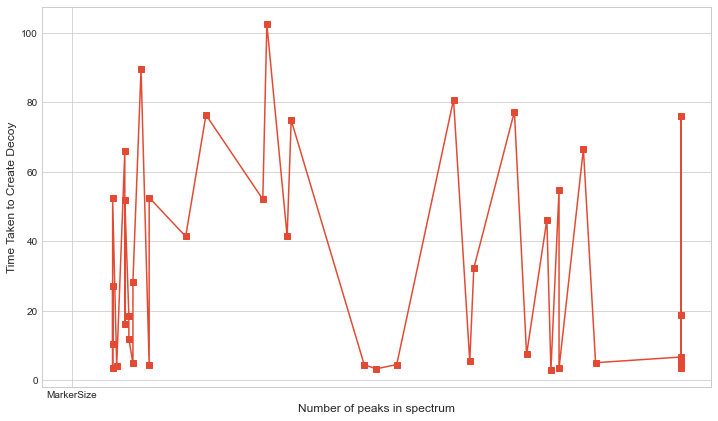

In [78]:
mass_list = []

for spec in with_decoy_spectrums[:40]:
    mass_list.append(len(spec.peaks.mz))
    
    
print(len(mass_list))
print(len(times_taken))

print(mass_list)
print(times_taken)

inds = mass_list.sort()




plt.figure(figsize=(12,7))
plt.plot(mass_list,times_taken, '-s','MarkerSize',10,)
plt.xlabel("Number of peaks in spectrum")
plt.ylabel("Time Taken to Create Decoy")




In [ ]:
def create_spectrum_based_decoy(s):
    parentmass = get_parent_peak(s)[0]
    parentintensity = get_parent_peak(s)[1]
    decoy_mz = np.array([parentmass])
    decoy_intensity = np.array([parentintensity])
    print("Parent peak equals: ", decoy_mz, "m/z, with intensity: ", decoy_intensity)
    peaks_in_target = len(s.peaks.mz)  

    candidate_spectra = []
    candidate_mzs = []
    candidate_intensities = []

    decoy_masses = [parentmass]
    decoy_intensities = [parentintensity]


    for spec in spectrums:
        if ispeakhere(spec, parentmass):       
            candidate_spectra.append(spec)

    print("Target decoy has this number of peaks: ", len(s.peaks.mz))

    i = 1


    while len(decoy_masses) < len(s.peaks.mz):  

        for cand in candidate_spectra:   
             random_index = np.random.choice(len(cand.peaks.mz), 5, replace = False) 
             random_masses = cand.peaks.mz[random_index]
             random_intensities = cand.peaks.intensities[random_index]       
             candidate_mzs.extend(random_masses)
             candidate_intensities.extend(random_intensities)


        candidate_ion_mass= random.choice(candidate_mzs)


        while((candidate_ion_mass >= parentmass or masswithin5ppm(candidate_ion_mass,decoy_masses)) == True):
            candidate_ion_mass= random.choice(candidate_mzs)  

        decoy_masses.append(candidate_ion_mass)
        index = candidate_mzs.index(candidate_ion_mass)
        decoy_intensities.append(candidate_intensities[index])
        print("Peak with mass:", candidate_ion_mass, "add")


    print("Decoy masses has this number: ", len(decoy_masses))
    print("Decoy intensities has this number: ", len(decoy_intensities))

    decoy_masses = np.asarray(decoy_masses, dtype=float) 
    decoy_intensities = np.asarray(decoy_intensities, dtype=float) 

    inds  = decoy_masses.argsort()

    sorted_intensities = decoy_intensities[inds]
    sorted_masses = decoy_masses[inds]

    decoy = Spectrum(sorted_masses, sorted_intensities) 

    complex_decoy_spectrums2.append(decoy)
    
    decoy.plot()


import time

start = time.time()

create_spectrum_based_decoy(with_decoy_spectrums[0]) 



end = time.time()
print(end - start)

In [ ]:
for d in no_decoy_spectrums:
    score, n_matches = cosine_greedy(d, complex_decoy_spectrums2[0])
    print(f"Cosine score is {score:.2f} with {n_matches} matched peaks")



In [ ]:
spectrums[1].get
    

In [ ]:
from matchms.exporting import save_as_json


save_as_json(complex_decoy_spectrums, r'C:\Users\User\Data\complex_decoy_spectrums')

In [ ]:
from matchms.exporting import save_as_mgf

save_as_mgf(naive_decoy_spectrums, r'C:\Users\User\Data\naive_decoy_spectrums')

In [ ]:
import csv   

with open('data.csv', 'w',) as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Mass', 'Intensities'])
    for spec in complex_decoy_spectrums:
        writer.writerow([spec.peaks.mz, spec.peaks.intensities])



In [ ]:
safety_naive_decoys = naive_decoy_spectrums.copy()
safety_complex_decoys = complex_decoy_spectrums.copy()

In [ ]:
from matchms.similarity import CosineGreedy


def calculate_similarities_spectral_lists(query, library):

    cosine_greedy = CosineGreedy(tolerance=0.2)

    counter = 1
    scores = []
    average_matches = 0
    milestone = 10000

    for spec in query:   
        for d in library:
            score, n_matches = cosine_greedy(d, spec)
            average_matches = average_matches + n_matches
            scores.append(score)
            counter += 1
            if(counter >= milestone):
                print(counter, "checkpoints")
                milestone += 10000

    score_average = sum(scores) / counter
    average_matches = average_matches / counter

    print("Score average is:", score_average, "match average is: ", average_matches)
    
    plt.figure(figsize=(12,7))
    hist = plt.hist(scores, np.arange(0,1, 0.05))
    plt.xlabel("cosine score of matches")
    plt.ylabel("number of queries in respective bin")
    

    

In [ ]:
calculate_similarities_spectral_lists(naive_decoy_spectrums, no_decoy_spectrums)

In [ ]:
calculate_similarities_spectral_lists(with_decoy_spectrums, no_decoy_spectrums)

In [ ]:
calculate_similarities_spectral_lists(no_decoy_spectrums, complex_decoy_spectrums)

In [ ]:
from matchms.similarity import CosineGreedy

cosine_greedy = CosineGreedy(tolerance=0.2)

naive_decoy_score_average = 0
counter = 1
naive_decoy_scores = []
naive_decoy_average_matches = 0

for spec in naive_decoy_spectrums:
    for d in no_decoy_spectrums:
        score, n_matches = cosine_greedy(d, spec)
        print(f"Cosine score is {score:.2f} with {n_matches} matched peaks")
        naive_decoy_score_average = naive_decoy_score_average + score
        naive_decoy_average_matches = naive_decoy_average_matches + n_matches
        naive_decoy_scores.append(score)
        counter += 1

naive_decoy_score_average = naive_score_average / counter
naive_decoy_average_matches = naive_decoy_average_matches / counter

print("Score average is:", naive_decoy_score_average, "match average is: ", naive_decoy_average_matches)
